In [33]:
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image #help to work with images
# %% Additional Imports for Complete Evaluation
from tqdm import tqdm
import seaborn as sns
import scipy
import pandas as pd
import os
import time
import json
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc, 
                           precision_recall_curve, average_precision_score)
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')

# Create directories for saving results
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

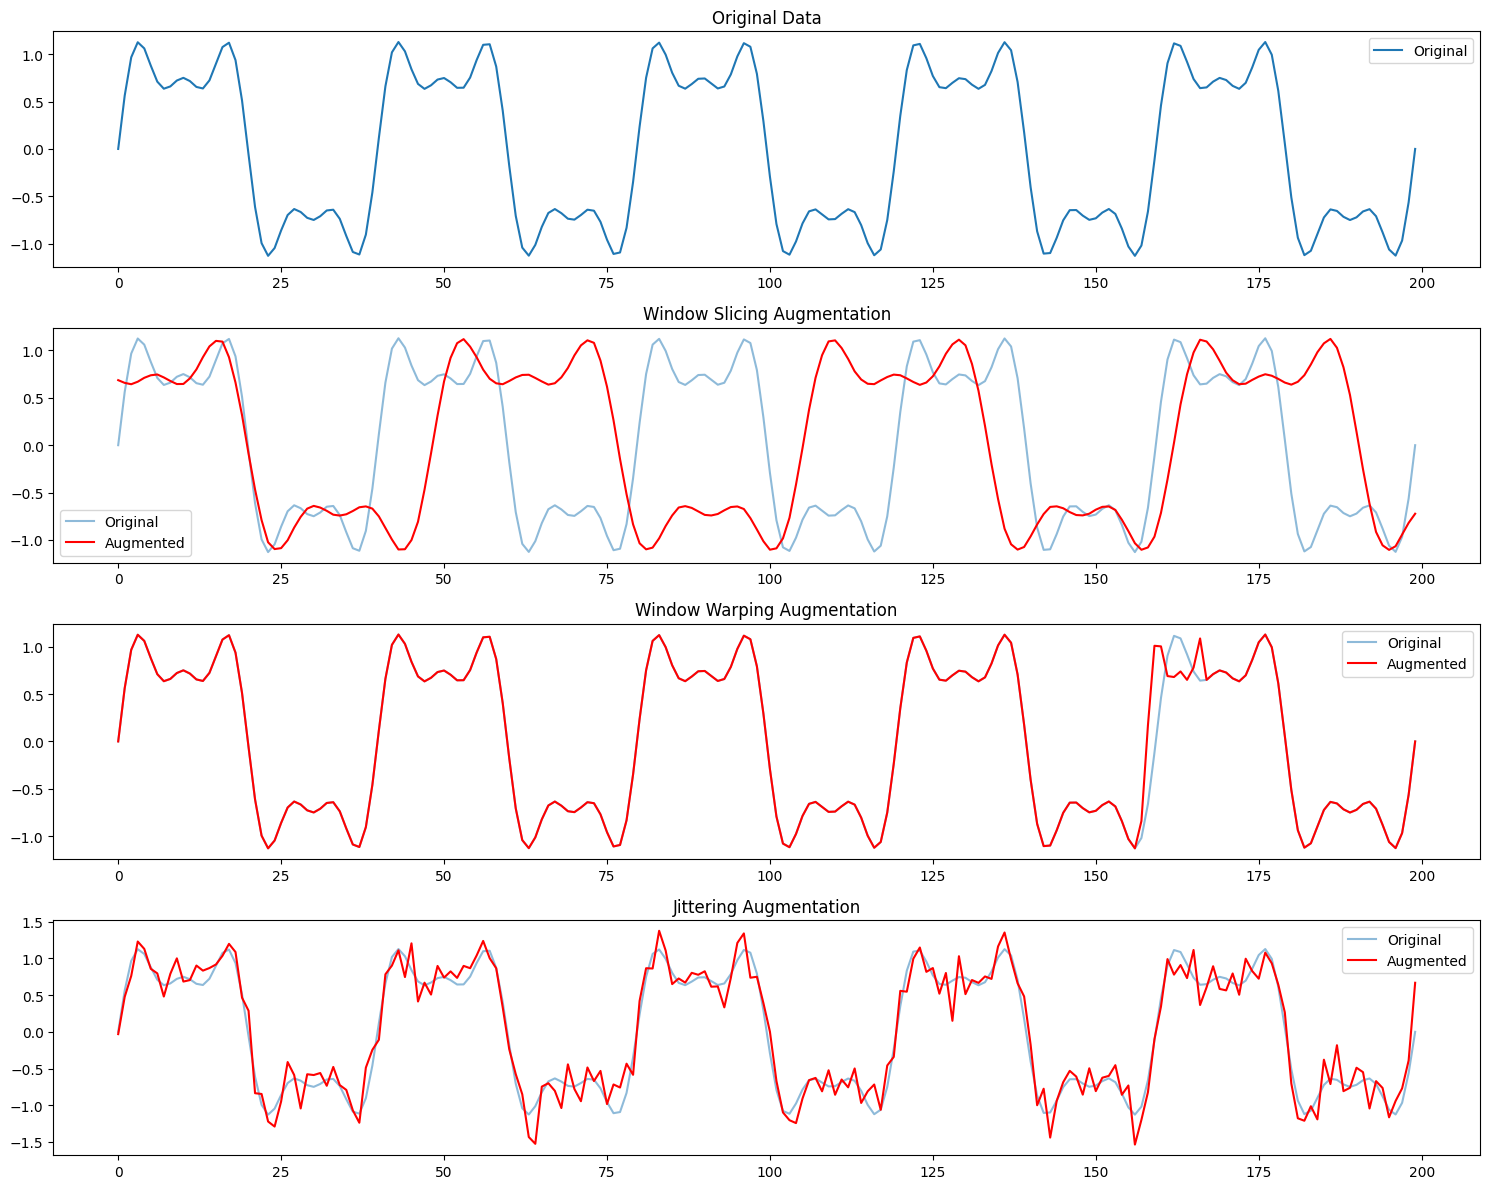

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8731157].


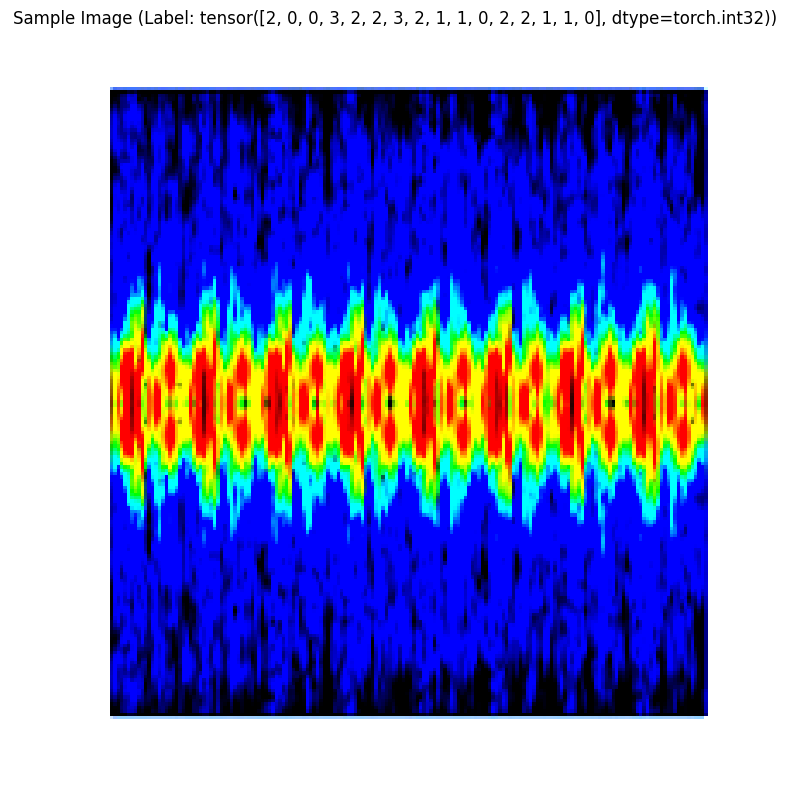

Dataset Details:
Total Images: 4849
Training Images: 4121
Validation Images: 242
Test Images: 486


In [34]:
# %% [markdown]
# # Time-Variant Data Augmentation Techniques

# %% Imports
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# %% Time-Variant Data Augmentation Techniques
class TimeVariantDataAugmentation:
    @staticmethod
    def window_slicing(data, slice_percentage=0.9):
        if not isinstance(data, torch.Tensor):
            data = torch.tensor(data, dtype=torch.float32)
        
        orig_width = data.shape[1]
        slice_width = int(orig_width * slice_percentage)
        max_start = orig_width - slice_width
        start_point = torch.randint(0, max_start + 1, (1,)).item()
        sliced_data = data[:, start_point:start_point + slice_width]

        augmented_data = torch.nn.functional.interpolate(
            sliced_data.unsqueeze(0), 
            size=orig_width, 
            mode='linear', 
            align_corners=False
        ).squeeze(0)
        return augmented_data

    @staticmethod
    def window_warping(data, warping_factors=[0.5, 2.0]):
        if not isinstance(data, torch.Tensor):
            data = torch.tensor(data, dtype=torch.float32)
        
        orig_width = data.shape[1]
        window_width = int(orig_width * 0.1)
        start_point = torch.randint(0, orig_width - window_width + 1, (1,)).item()
        warping_factor = np.random.choice(warping_factors)
        window = data[:, start_point:start_point + window_width]

        warped_window_width = int(window_width * warping_factor)
        warped_window = torch.nn.functional.interpolate(
            window.unsqueeze(0), 
            size=warped_window_width, 
            mode='linear', 
            align_corners=False
        ).squeeze(0)

        augmented_data = data.clone()
        end_point = start_point + warped_window_width
        if warped_window_width < window_width:
            augmented_data[:, start_point:end_point] = warped_window
        else:
            augmented_data[:, start_point:start_point + window_width] = warped_window[:window_width]
        
        return augmented_data

    @staticmethod
    def jittering(data, mean=0, std_dev=0.03):
        if not isinstance(data, torch.Tensor):
            data = torch.tensor(data, dtype=torch.float32)
        noise = torch.normal(mean, std_dev, size=data.shape)
        return data + noise

# %% Stochastic Augmentation Class
class StochasticAugmentation:
    def __init__(self, augmentation_methods):
        self.augmentation_methods = augmentation_methods
    
    def __call__(self, data):
        method = np.random.choice(self.augmentation_methods)
        return method(data)

# %% Custom Image Dataset Class
class CustomImageDataset(Dataset):
    def __init__(self, base_dir, subfolders, transform=None):
        self.base_dir = base_dir
        self.subfolders = subfolders
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Initialize label encoder
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(subfolders)
        
        # Collect image paths and labels
        for subfolder in subfolders:
            folder_path = os.path.join(base_dir, subfolder)
            for img_name in os.listdir(folder_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(folder_path, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(subfolder)
        
        # Encode labels
        self.labels = self.label_encoder.transform(self.labels)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# %% Visualization Function
def visualize_augmentation():
    t = torch.linspace(0, 10*torch.pi, 200)
    sample_data = torch.sin(t) + 0.5 * torch.sin(3*t) + 0.25 * torch.sin(5*t)
    sample_data = sample_data.unsqueeze(0)

    augmentation_methods = [
        ("Window Slicing", lambda x: TimeVariantDataAugmentation.window_slicing(x, slice_percentage=0.7)),
        ("Window Warping", lambda x: TimeVariantDataAugmentation.window_warping(x, warping_factors=[0.5])),
        ("Jittering", lambda x: TimeVariantDataAugmentation.jittering(x, mean=0, std_dev=0.2))
    ]
    
    plt.figure(figsize=(15, 12))
    plt.subplot(4, 1, 1)
    plt.title("Original Data")
    plt.plot(sample_data.numpy().flatten(), label='Original')
    plt.legend()
    
    for i, (name, aug_method) in enumerate(augmentation_methods, start=2):
        augmented_data = aug_method(sample_data)
        plt.subplot(4, 1, i)
        plt.title(f"{name} Augmentation")
        plt.plot(sample_data.numpy().flatten(), label='Original', alpha=0.5)
        plt.plot(augmented_data.numpy().flatten(), label='Augmented', color='red')
        plt.legend()

    plt.tight_layout()
    plt.show()

# %% Define dataset parameters
base_dir = r'DIAT-uSAT_dataset'
subfolders = [
    "3_long_blade_rotor",
    "3_short_blade_rotor", 
    "Bird", 
    "Bird+mini-helicopter", 
    "drone", 
    "rc_plane"
]

# %% Define transformations
# Training transforms (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation/Test transforms (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# %% Load datasets with different transforms
train_dataset = CustomImageDataset(base_dir, subfolders, transform=train_transform)
val_dataset = CustomImageDataset(base_dir, subfolders, transform=val_test_transform)
test_dataset = CustomImageDataset(base_dir, subfolders, transform=val_test_transform)

# %% Split datasets
train_size = int(0.85 * len(train_dataset))
val_size = int(0.05 * len(train_dataset))
test_size = len(train_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(train_dataset, [train_size, val_size, test_size])

# Manually shuffle the training dataset
torch.manual_seed(42)
train_indices = torch.randperm(len(train_dataset))
train_dataset = Subset(train_dataset, train_indices)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=False)

# %% Visualization
visualize_augmentation()

# %% Sample Visualization
sample_image, sample_label = next(iter(train_loader))
sample_image = sample_image[0].permute(1, 2, 0)

plt.figure(figsize=(10, 10))
plt.imshow(sample_image)
plt.title(f"Sample Image (Label: {sample_label})")
plt.axis('off')
plt.show()

# %% Print dataset details
print("Dataset Details:")
print(f"Total Images: {len(train_dataset) + len(val_dataset) + len(test_dataset)}")
print(f"Training Images: {len(train_dataset)}")
print(f"Validation Images: {len(val_dataset)}")
print(f"Test Images: {len(test_dataset)}")


In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from tqdm import tqdm

# Define the Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 1, kernel_size=1)  # Reduce channels to 1
        self.conv2 = nn.Conv2d(1, 1, kernel_size=3, padding=1)  # Learn spatial weights
        self.sigmoid = nn.Sigmoid()  # Normalize attention map to [0, 1]

    def forward(self, x):
        attn = self.conv1(x)  # Reduce channel dimension
        attn = self.conv2(attn)  # Learn spatial relationships
        attn = self.sigmoid(attn)  # Normalize
        return x * attn  # Apply attention

# Define the Custom CNN with integrated Spatial Attention
class CustomCNNWithAttention(nn.Module):
    def __init__(self, num_classes=6):
        super(CustomCNNWithAttention, self).__init__()
        # 1st Convolutional Block
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 2nd Convolutional Block
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 3rd Convolutional Block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 4th Convolutional Block
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Attention Module
        self.attention = SpatialAttention(in_channels=128)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, num_classes)  # Output for `num_classes` classes

        # Dropout for Regularization
        self.dropout = nn.Dropout(0.6)  # Between 0.5 and 0.7

    def forward(self, x):
        # 1st Convolutional Block
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        
        # 2nd Convolutional Block
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        
        # 3rd Convolutional Block
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # 4th Convolutional Block
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))

        # Apply Attention Mechanism
        x = self.attention(x)

        # Global Average Pooling
        x = self.global_avg_pool(x)
        
        # Flatten the output
        x = torch.flatten(x, 1)
        
        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x



In [36]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_deepercnn = CustomCNNWithAttention(num_classes=6)
model_deepercnn.to(device)

CustomCNNWithAttention(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding

In [37]:
# Loss and optimizer for Deeper CNN
criterion = nn.CrossEntropyLoss()
optimizer_deepercnn = optim.Adam(model_deepercnn.parameters(), lr=0.001, weight_decay=1e-5)
scheduler_deepercnn = optim.lr_scheduler.ReduceLROnPlateau(optimizer_deepercnn, mode='min', factor=0.5, patience=2, min_lr=1e-7)

In [38]:
# %% Complete Training Function with Early Stopping and Progress Bars
from tqdm import tqdm
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    """
    Complete training function with early stopping, progress bars, and proper model saving
    """
    model.train()
    best_acc = 0.0
    patience = 5
    patience_counter = 0
    
    # Lists to store metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    learning_rates = []
    
    print("="*60)
    print("TRAINING STARTED")
    print("="*60)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_train = 0
        
        # Progress bar for training
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        
        for images, labels in train_pbar:
            images = images.to(device)
            labels = labels.to(device, dtype=torch.long)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_train += images.size(0)
            
            # Update progress bar
            current_acc = running_corrects.double() / total_train
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}', 
                'Acc': f'{current_acc:.4f}'
            })
        
        # Calculate training metrics
        epoch_loss = running_loss / total_train
        epoch_acc = running_corrects.double() / total_train
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())
        learning_rates.append(optimizer.param_groups[0]['lr'])
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_total = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
            
            for images, labels in val_pbar:
                images = images.to(device)
                labels = labels.to(device, dtype=torch.long)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * images.size(0)
                val_corrects += torch.sum(preds == labels.data)
                val_total += images.size(0)
                
                # Update progress bar
                current_val_acc = val_corrects.double() / val_total
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}', 
                    'Acc': f'{current_val_acc:.4f}'
                })
        
        val_loss = val_loss / val_total
        val_acc = val_corrects.double() / val_total
        
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())
        
        # Learning rate scheduling
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)
        else:
            scheduler.step()
        
        # Print epoch summary
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")
        print(f"  Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"  LR: {optimizer.param_groups[0]['lr']:.2e}")
        print(f"  Gap: {abs(epoch_acc.item() - val_acc.item()):.4f}")
        
        # Save best model and early stopping
        if val_acc > best_acc:
            best_acc = val_acc
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_acc': best_acc,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
                'learning_rates': learning_rates
            }, "models/best_model_CustomCNNWithAttention.pt")
            print(f"  → New best model saved! Val Acc: {best_acc:.4f}")
        else:
            patience_counter += 1
            print(f"  → No improvement ({patience_counter}/{patience})")
            
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}. Best Val Acc: {best_acc:.4f}")
                break
        
        model.train()
    
    # Save training history
    training_history = {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'learning_rates': learning_rates,
        'best_val_acc': best_acc.item()
    }
    
    with open('results/training_history.json', 'w') as f:
        json.dump(training_history, f, indent=4)
    
    print("\n" + "="*60)
    print("TRAINING COMPLETED")
    print(f"Best Validation Accuracy: {best_acc:.4f}")
    print("="*60)
    
    return training_history

In [39]:
# %% Train the model with complete function
torch.cuda.empty_cache() 

# Define class names for testing
class_names = [
    "3 Long Blade Rotor", 
    "3 Short Blade Rotor", 
    "Bird", 
    "Bird+mini-helicopter", 
    "Drone", 
    "RC Plane"
]

# Train the model
training_history = train_model(
    model=model_deepercnn, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer_deepercnn, 
    scheduler=scheduler_deepercnn, 
    num_epochs=20
)

TRAINING STARTED


Epoch 1/20 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s, Loss=0.3554, Acc=0.7397]



Epoch [1/20]
  Train Loss: 0.8555, Train Acc: 0.6690
  Val Loss: 0.7051, Val Acc: 0.7397
  LR: 1.00e-03
  Gap: 0.0707
  → New best model saved! Val Acc: 0.7397


Epoch 2/20 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.58it/s, Loss=0.1684, Acc=0.8636]



Epoch [2/20]
  Train Loss: 0.4541, Train Acc: 0.8367
  Val Loss: 0.3647, Val Acc: 0.8636
  LR: 1.00e-03
  Gap: 0.0269
  → New best model saved! Val Acc: 0.8636


Epoch 3/20 [Val]: 100%|██████████| 16/16 [00:05<00:00,  2.84it/s, Loss=0.1527, Acc=0.9050]



Epoch [3/20]
  Train Loss: 0.3403, Train Acc: 0.8850
  Val Loss: 0.3206, Val Acc: 0.9050
  LR: 1.00e-03
  Gap: 0.0200
  → New best model saved! Val Acc: 0.9050


Epoch 4/20 [Val]: 100%|██████████| 16/16 [00:05<00:00,  3.10it/s, Loss=0.1978, Acc=0.8512]



Epoch [4/20]
  Train Loss: 0.2631, Train Acc: 0.9146
  Val Loss: 0.4452, Val Acc: 0.8512
  LR: 1.00e-03
  Gap: 0.0633
  → No improvement (1/5)


Epoch 5/20 [Val]: 100%|██████████| 16/16 [00:04<00:00,  3.24it/s, Loss=0.0617, Acc=0.9380]



Epoch [5/20]
  Train Loss: 0.2403, Train Acc: 0.9180
  Val Loss: 0.1826, Val Acc: 0.9380
  LR: 1.00e-03
  Gap: 0.0200
  → New best model saved! Val Acc: 0.9380


Epoch 6/20 [Val]: 100%|██████████| 16/16 [00:05<00:00,  3.03it/s, Loss=0.4137, Acc=0.7645]



Epoch [6/20]
  Train Loss: 0.2105, Train Acc: 0.9308
  Val Loss: 0.6587, Val Acc: 0.7645
  LR: 1.00e-03
  Gap: 0.1664
  → No improvement (1/5)


Epoch 7/20 [Val]: 100%|██████████| 16/16 [00:04<00:00,  3.32it/s, Loss=0.0268, Acc=0.9091]



Epoch [7/20]
  Train Loss: 0.1645, Train Acc: 0.9454
  Val Loss: 0.2605, Val Acc: 0.9091
  LR: 1.00e-03
  Gap: 0.0363
  → No improvement (2/5)


Epoch 8/20 [Val]: 100%|██████████| 16/16 [00:04<00:00,  3.44it/s, Loss=0.4317, Acc=0.8430]



Epoch [8/20]
  Train Loss: 0.1551, Train Acc: 0.9520
  Val Loss: 0.4280, Val Acc: 0.8430
  LR: 5.00e-04
  Gap: 0.1090
  → No improvement (3/5)


Epoch 9/20 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.64it/s, Loss=0.1045, Acc=0.9421]



Epoch [9/20]
  Train Loss: 0.1040, Train Acc: 0.9685
  Val Loss: 0.1659, Val Acc: 0.9421
  LR: 5.00e-04
  Gap: 0.0263
  → New best model saved! Val Acc: 0.9421


Epoch 10/20 [Val]: 100%|██████████| 16/16 [00:05<00:00,  2.90it/s, Loss=0.1763, Acc=0.9711]



Epoch [10/20]
  Train Loss: 0.0917, Train Acc: 0.9714
  Val Loss: 0.0830, Val Acc: 0.9711
  LR: 5.00e-04
  Gap: 0.0003
  → New best model saved! Val Acc: 0.9711


Epoch 11/20 [Val]: 100%|██████████| 16/16 [00:05<00:00,  2.89it/s, Loss=0.2372, Acc=0.9669]



Epoch [11/20]
  Train Loss: 0.0997, Train Acc: 0.9660
  Val Loss: 0.0911, Val Acc: 0.9669
  LR: 5.00e-04
  Gap: 0.0009
  → No improvement (1/5)


Epoch 12/20 [Val]: 100%|██████████| 16/16 [00:05<00:00,  2.70it/s, Loss=0.1276, Acc=0.9628]



Epoch [12/20]
  Train Loss: 0.0809, Train Acc: 0.9723
  Val Loss: 0.0734, Val Acc: 0.9628
  LR: 5.00e-04
  Gap: 0.0095
  → No improvement (2/5)


Epoch 13/20 [Val]: 100%|██████████| 16/16 [00:04<00:00,  3.39it/s, Loss=0.1288, Acc=0.9876]



Epoch [13/20]
  Train Loss: 0.0827, Train Acc: 0.9740
  Val Loss: 0.0425, Val Acc: 0.9876
  LR: 5.00e-04
  Gap: 0.0136
  → New best model saved! Val Acc: 0.9876


Epoch 14/20 [Val]: 100%|██████████| 16/16 [00:04<00:00,  3.46it/s, Loss=0.0971, Acc=0.9711]



Epoch [14/20]
  Train Loss: 0.0721, Train Acc: 0.9752
  Val Loss: 0.0745, Val Acc: 0.9711
  LR: 5.00e-04
  Gap: 0.0042
  → No improvement (1/5)


Epoch 15/20 [Val]: 100%|██████████| 16/16 [00:04<00:00,  3.33it/s, Loss=0.0307, Acc=0.9793]



Epoch [15/20]
  Train Loss: 0.0764, Train Acc: 0.9765
  Val Loss: 0.0486, Val Acc: 0.9793
  LR: 5.00e-04
  Gap: 0.0029
  → No improvement (2/5)


Epoch 16/20 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s, Loss=0.2374, Acc=0.9876]



Epoch [16/20]
  Train Loss: 0.0615, Train Acc: 0.9786
  Val Loss: 0.0441, Val Acc: 0.9876
  LR: 2.50e-04
  Gap: 0.0090
  → No improvement (3/5)


Epoch 17/20 [Val]: 100%|██████████| 16/16 [00:06<00:00,  2.56it/s, Loss=0.0263, Acc=0.9752]



Epoch [17/20]
  Train Loss: 0.0393, Train Acc: 0.9862
  Val Loss: 0.0433, Val Acc: 0.9752
  LR: 2.50e-04
  Gap: 0.0110
  → No improvement (4/5)


Epoch 18/20 [Val]: 100%|██████████| 16/16 [00:05<00:00,  2.74it/s, Loss=0.0173, Acc=1.0000]



Epoch [18/20]
  Train Loss: 0.0417, Train Acc: 0.9859
  Val Loss: 0.0152, Val Acc: 1.0000
  LR: 2.50e-04
  Gap: 0.0141
  → New best model saved! Val Acc: 1.0000


Epoch 19/20 [Val]: 100%|██████████| 16/16 [00:04<00:00,  3.33it/s, Loss=0.2821, Acc=0.9752]



Epoch [19/20]
  Train Loss: 0.0343, Train Acc: 0.9886
  Val Loss: 0.0604, Val Acc: 0.9752
  LR: 2.50e-04
  Gap: 0.0134
  → No improvement (1/5)


Epoch 20/20 [Val]: 100%|██████████| 16/16 [00:07<00:00,  2.24it/s, Loss=0.0296, Acc=0.9959]


Epoch [20/20]
  Train Loss: 0.0346, Train Acc: 0.9888
  Val Loss: 0.0288, Val Acc: 0.9959
  LR: 2.50e-04
  Gap: 0.0070
  → No improvement (2/5)

TRAINING COMPLETED
Best Validation Accuracy: 1.0000


In [40]:
# %% Complete Testing Function with Comprehensive Metrics
def test_model(model, test_loader, criterion, device, class_names):
    """
    Complete testing function with comprehensive evaluation metrics
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_test = 0
    all_preds = []
    all_labels = []
    all_probs = []
    inference_times = []

    print("="*60)
    print("TESTING STARTED")
    print("="*60)

    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc="Testing")
        
        for inputs, labels in test_pbar:
            start_time = time.time()
            
            inputs = inputs.to(device)
            labels = labels.to(device).long()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            inference_time = time.time() - start_time
            inference_times.append(inference_time)
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_test += labels.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
            
            # Update progress bar
            current_acc = running_corrects.double() / total_test
            test_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}', 
                'Acc': f'{current_acc:.4f}'
            })

    test_loss = running_loss / total_test
    test_acc = running_corrects.double() / total_test
    avg_inference_time = np.mean(inference_times)

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Average Inference Time: {avg_inference_time:.4f}s per batch")

    # Classification Report
    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Save classification report
    with open("results/classification_report.json", "w") as f:
        json.dump(report, f, indent=4)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Save confusion matrix
    np.save("results/confusion_matrix.npy", cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('results/confusion_matrix.pdf', dpi=300, bbox_inches='tight')
    plt.savefig('results/confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # ROC Curve & AUC
    all_probs = np.array(all_probs)
    if len(class_names) > 2:
        fpr, tpr, roc_auc = {}, {}, {}
        plt.figure(figsize=(10, 8))
        
        for i in range(len(class_names)):
            fpr[i], tpr[i], _ = roc_curve((np.array(all_labels) == i).astype(int), all_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], lw=2, 
                    label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

        macro_auc = np.mean([auc(fpr[i], tpr[i]) for i in range(len(class_names))])
        print(f"\nMacro Average AUC: {macro_auc:.4f}")

        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.savefig('results/roc_curves.pdf', dpi=300, bbox_inches='tight')
        plt.savefig('results/roc_curves.png', dpi=300, bbox_inches='tight')
        plt.show()

    # Save test results
    test_results = {
        'test_loss': float(test_loss),
        'test_accuracy': float(test_acc.item()),
        'macro_auc': float(macro_auc),
        'avg_inference_time': float(avg_inference_time),
        'all_labels': [int(x) for x in all_labels],
        'all_preds': [int(x) for x in all_preds],
        'all_probs': all_probs.tolist()
    }
    
    with open('results/test_results.json', 'w') as f:
        json.dump(test_results, f, indent=4)

    print("\n" + "="*60)
    print("TESTING COMPLETED")
    print("="*60)
    
    return all_labels, all_preds, all_probs, test_acc.item()

TESTING STARTED


Testing: 100%|██████████| 31/31 [00:10<00:00,  2.85it/s, Loss=0.0001, Acc=0.9897]



Test Loss: 0.0258
Test Accuracy: 0.9897
Average Inference Time: 0.0107s per batch

Classification Report:
                      precision    recall  f1-score   support

  3 Long Blade Rotor       0.99      0.98      0.98        81
 3 Short Blade Rotor       0.97      0.97      0.97        78
                Bird       1.00      1.00      1.00        69
Bird+mini-helicopter       0.99      1.00      0.99        77
               Drone       1.00      1.00      1.00        85
            RC Plane       0.99      0.99      0.99        96

            accuracy                           0.99       486
           macro avg       0.99      0.99      0.99       486
        weighted avg       0.99      0.99      0.99       486


Confusion Matrix:
[[79  2  0  0  0  0]
 [ 1 76  0  0  0  1]
 [ 0  0 69  0  0  0]
 [ 0  0  0 77  0  0]
 [ 0  0  0  0 85  0]
 [ 0  0  0  1  0 95]]


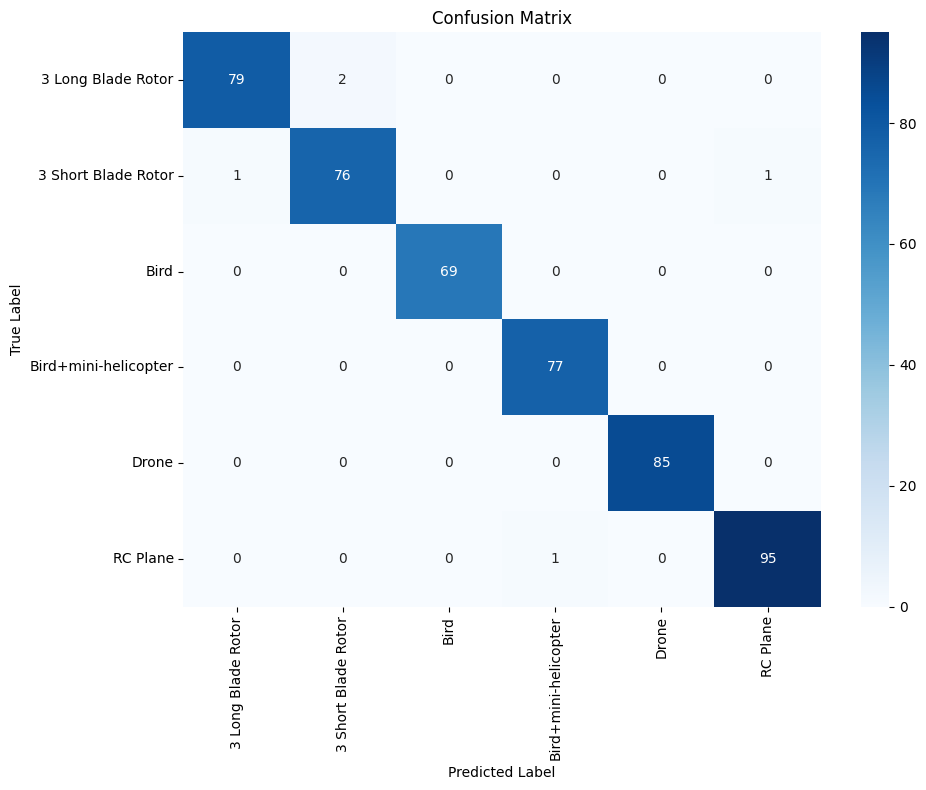


Macro Average AUC: 0.9999


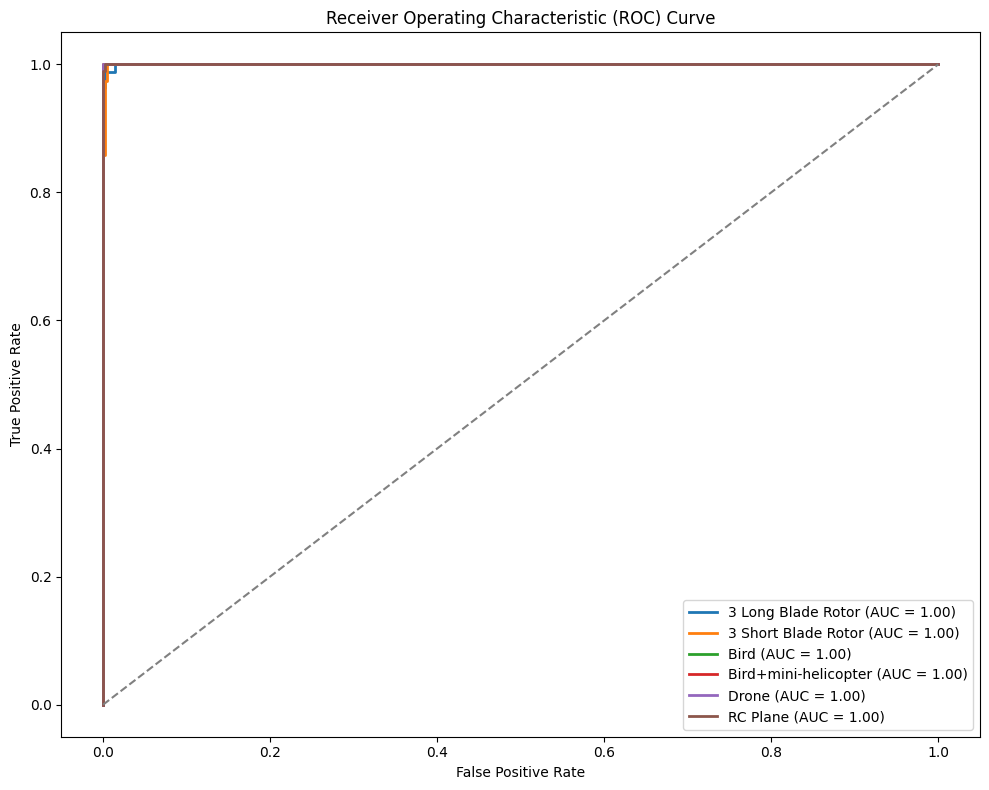


TESTING COMPLETED


In [41]:
# %% Test the model with complete function
# Load best model
model_deepercnn.load_state_dict(torch.load("models/best_model_CustomCNNWithAttention.pt")['model_state_dict'])

# Test the model
all_labels, all_preds, all_probs, test_acc = test_model(
    model=model_deepercnn, 
    test_loader=test_loader, 
    criterion=criterion, 
    device=device, 
    class_names=class_names
)

COMPREHENSIVE MODEL EVALUATION FOR TOP-TIER PUBLICATIONS


Testing: 100%|██████████| 31/31 [00:11<00:00,  2.70it/s]



1. BASIC PERFORMANCE METRICS:
   Test Loss: 0.0271
   Test Accuracy: 0.9918
   Average Inference Time: 0.0090s per batch

2. ENHANCED CONFUSION MATRIX:


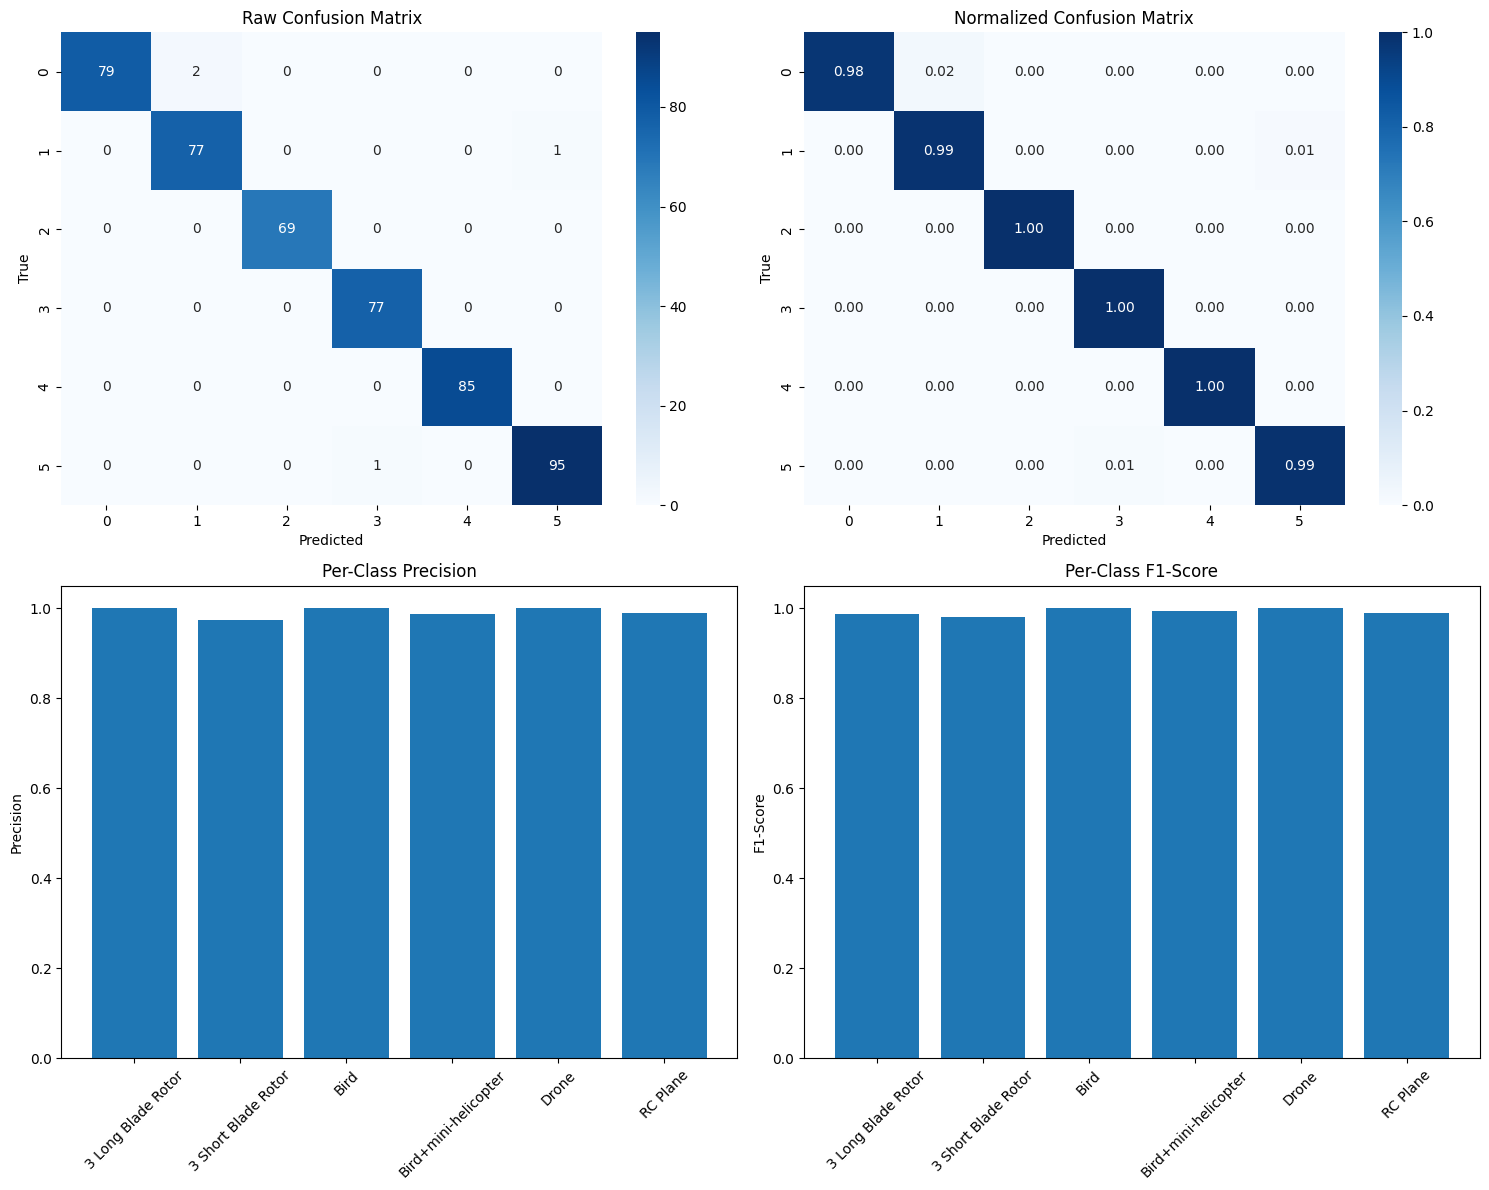


3. ROC CURVES ANALYSIS:


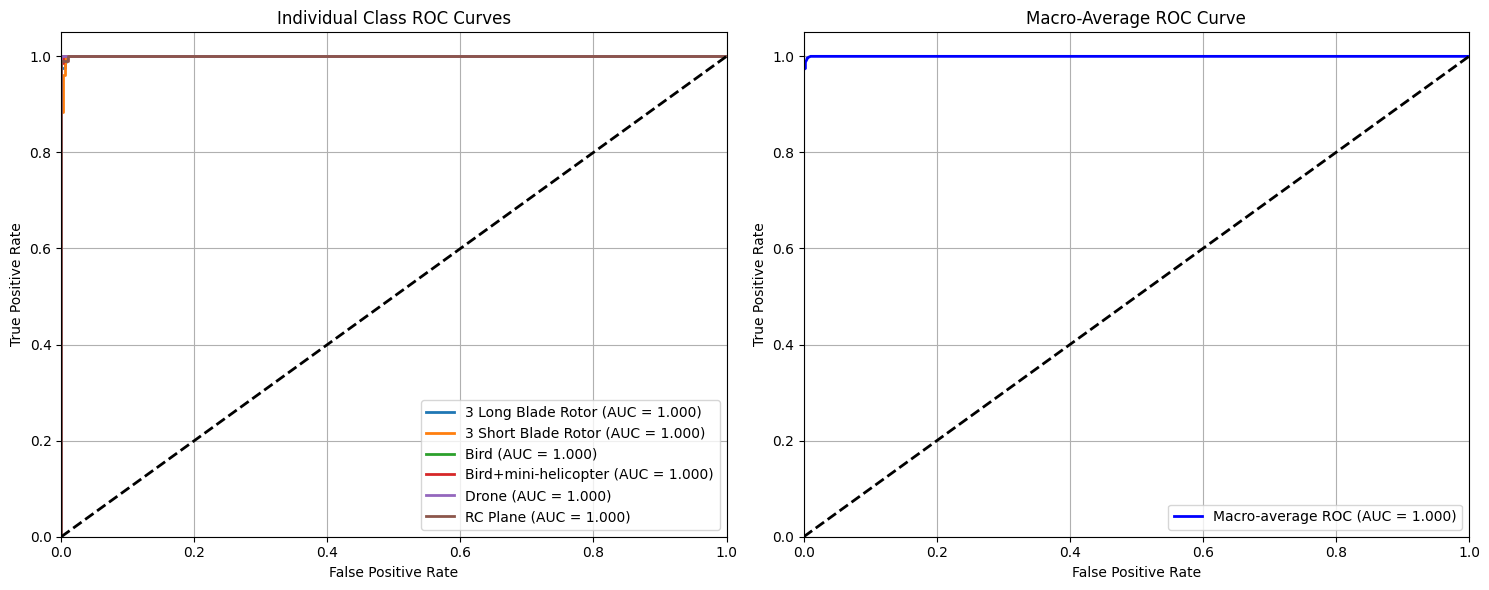

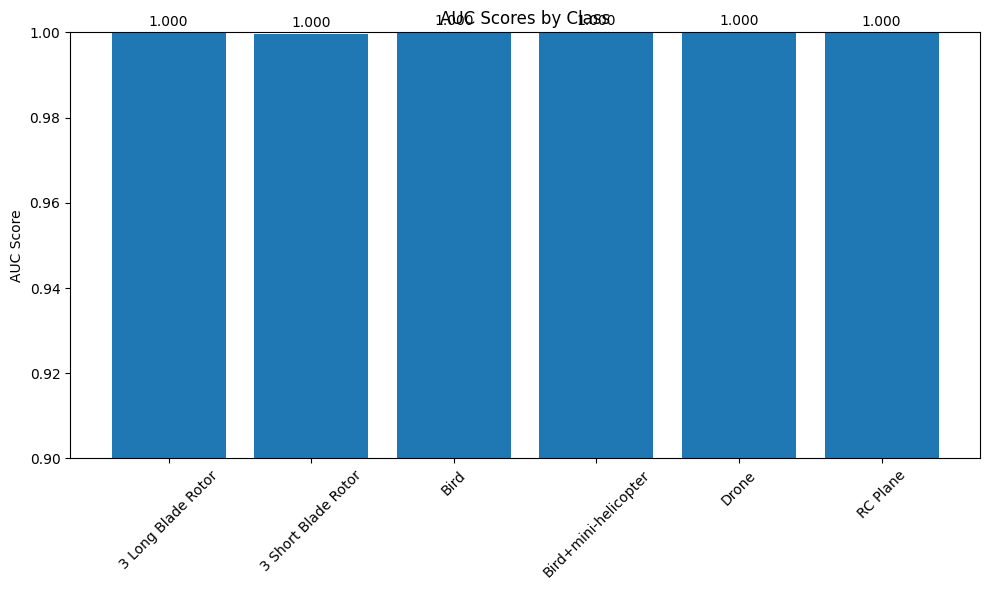


4. PRECISION-RECALL CURVES:


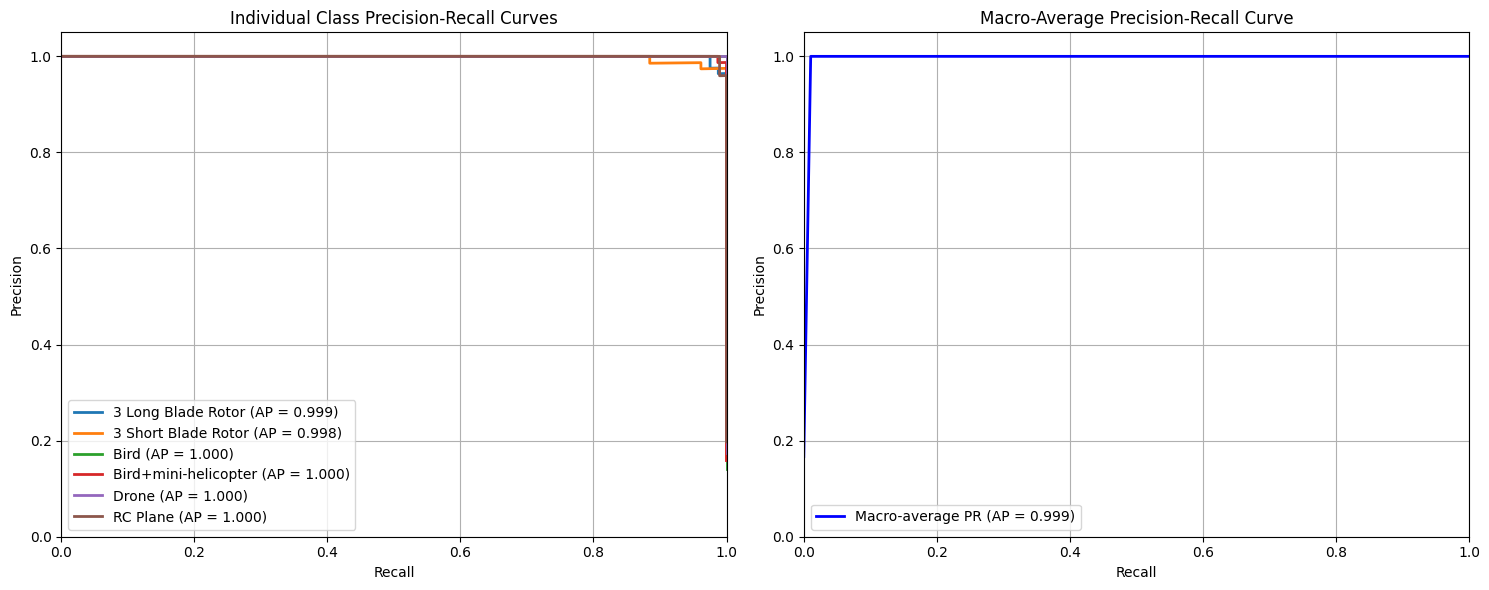

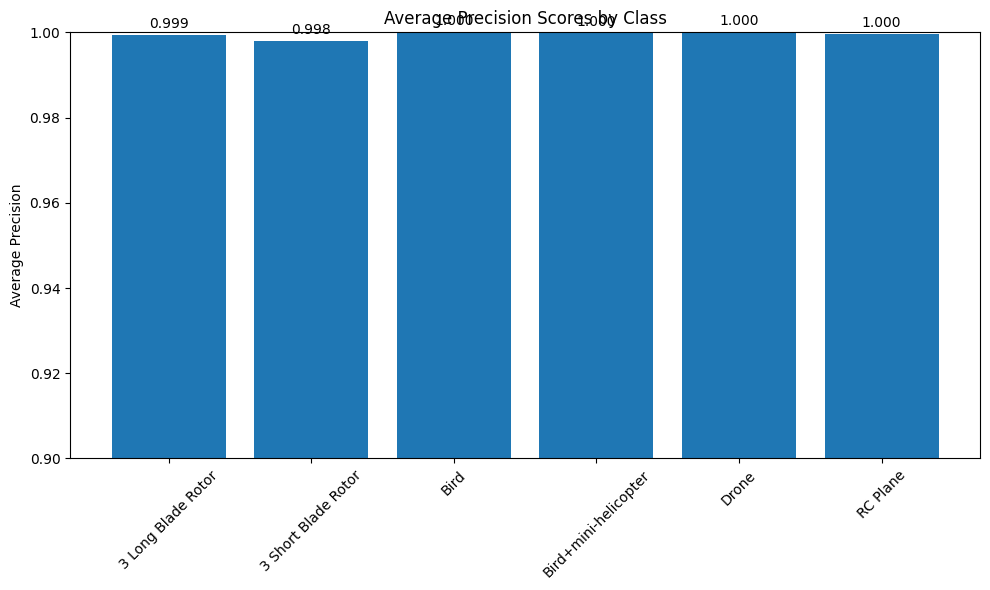


5. CALIBRATION ANALYSIS:


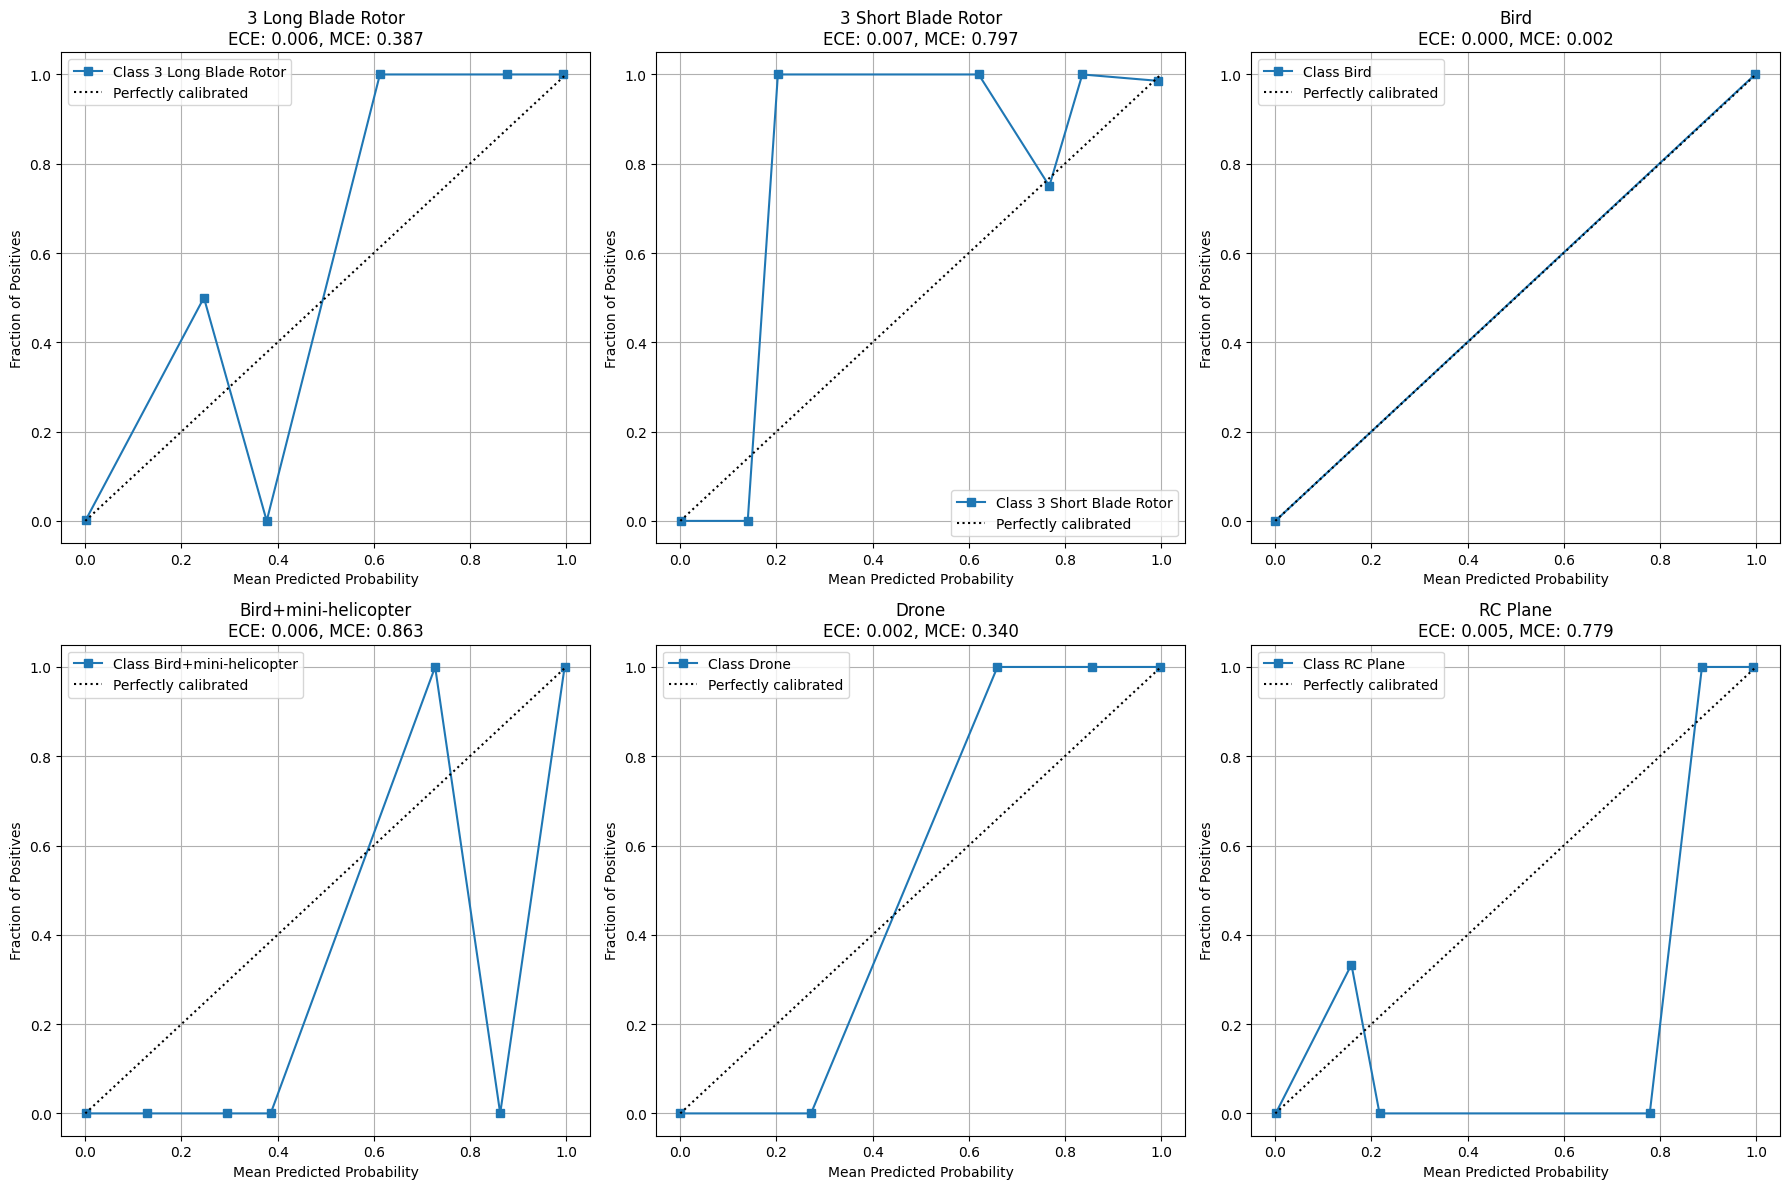

   Mean ECE: 0.0045
   Mean MCE: 0.5280

6. STATISTICAL SIGNIFICANCE ANALYSIS:
   Accuracy: 0.9918
   95% Confidence Interval: [0.9835, 0.9979]

7. COMPUTATIONAL EFFICIENCY ANALYSIS:
   Total Parameters: 167,185
   Trainable Parameters: 167,185
   GPU Memory Usage: 152.02 MB

8. ERROR ANALYSIS:
   Total Errors: 4
   Error Rate: 0.0082


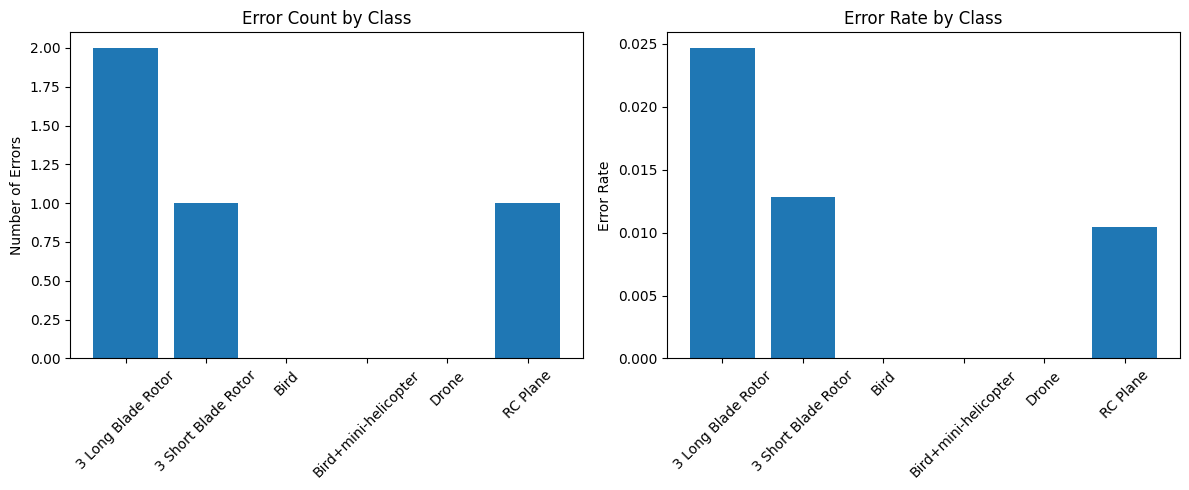


9. FEATURE IMPORTANCE ANALYSIS:


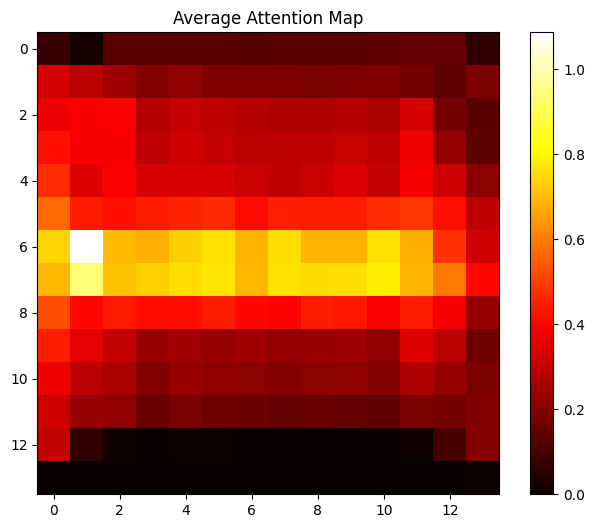

   Attention analysis completed

10. ABLATION STUDY:
   Note: Full ablation study requires training multiple model variants
   This is a placeholder for the ablation analysis

EVALUATION COMPLETE - ALL METRICS SAVED
Generated files:
- enhanced_confusion_matrix.pdf/png
- roc_curves.pdf/png
- auc_scores.pdf/png
- precision_recall_curves.pdf/png
- ap_scores.pdf/png
- calibration_curves.pdf/png
- error_analysis.pdf/png
- attention_heatmap.pdf/png
- Various JSON metric files


In [42]:
# %% COMPREHENSIVE MODEL EVALUATION FOR TOP-TIER PUBLICATIONS
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc, 
                           precision_recall_curve, average_precision_score)
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.preprocessing import label_binarize
import time
import json
import pandas as pd
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class ComprehensiveModelEvaluator:
    def __init__(self, model, test_loader, criterion, device, class_names):
        self.model = model.to(device)
        self.test_loader = test_loader
        self.criterion = criterion
        self.device = device
        self.class_names = class_names
        self.num_classes = len(class_names)
        
    def evaluate_model(self):
        """Complete model evaluation with all metrics"""
        print("="*80)
        print("COMPREHENSIVE MODEL EVALUATION FOR TOP-TIER PUBLICATIONS")
        print("="*80)
        
        # 1. Basic Testing
        results = self._basic_testing()
        
        # 2. Enhanced Confusion Matrix
        self._plot_enhanced_confusion_matrix(results['all_labels'], results['all_preds'])
        
        # 3. ROC Curves with AUC Analysis
        self._plot_roc_curves(results['all_labels'], results['all_probs'])
        
        # 4. Precision-Recall Curves
        self._plot_precision_recall_curves(results['all_labels'], results['all_probs'])
        
        # 5. Calibration Analysis
        self._plot_calibration_curves(results['all_labels'], results['all_probs'])
        
        # 6. Statistical Significance Tests
        self._statistical_significance_analysis(results)
        
        # 7. Computational Efficiency Metrics
        self._computational_efficiency_analysis()
        
        # 8. Error Analysis
        self._error_analysis(results['all_labels'], results['all_preds'], results['all_probs'])
        
        # 9. Feature Importance Analysis
        self._feature_importance_analysis()
        
        # 10. Ablation Studies
        self._ablation_study()
        
        return results
    
    def _basic_testing(self):
        """Basic model testing with metric collection"""
        self.model.eval()
        running_loss = 0.0
        running_corrects = 0
        total_test = 0
        all_preds = []
        all_labels = []
        all_probs = []
        inference_times = []

        with torch.no_grad():
            for inputs, labels in tqdm(self.test_loader, desc="Testing", ncols=100, dynamic_ncols=True):
                start_time = time.time()
                
                inputs = inputs.to(self.device)
                labels = labels.to(self.device).long()
                
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                
                inference_time = time.time() - start_time
                inference_times.append(inference_time)
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_test += labels.size(0)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
        
        test_loss = running_loss / total_test
        test_acc = running_corrects.double() / total_test
        avg_inference_time = np.mean(inference_times)
        
        print(f"\n1. BASIC PERFORMANCE METRICS:")
        print(f"   Test Loss: {test_loss:.4f}")
        print(f"   Test Accuracy: {test_acc:.4f}")
        print(f"   Average Inference Time: {avg_inference_time:.4f}s per batch")
        
        return {
            'all_labels': np.array(all_labels),
            'all_preds': np.array(all_preds),
            'all_probs': np.array(all_probs),
            'test_loss': test_loss,
            'test_acc': test_acc.item(),
            'inference_times': inference_times
        }
    
    def _plot_enhanced_confusion_matrix(self, labels, preds):
        """Enhanced confusion matrix with normalization and per-class metrics"""
        print(f"\n2. ENHANCED CONFUSION MATRIX:")
        
        # Raw confusion matrix
        cm = confusion_matrix(labels, preds)
        
        # Normalized confusion matrix
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        # Per-class metrics
        report = classification_report(labels, preds, target_names=self.class_names, output_dict=True)
        
        # Create comprehensive plot
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Raw confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
        axes[0,0].set_title('Raw Confusion Matrix')
        axes[0,0].set_xlabel('Predicted')
        axes[0,0].set_ylabel('True')
        
        # Normalized confusion matrix
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=axes[0,1])
        axes[0,1].set_title('Normalized Confusion Matrix')
        axes[0,1].set_xlabel('Predicted')
        axes[0,1].set_ylabel('True')
        
        # Per-class accuracy
        class_accuracies = [report[cls]['precision'] for cls in self.class_names]
        axes[1,0].bar(self.class_names, class_accuracies)
        axes[1,0].set_title('Per-Class Precision')
        axes[1,0].set_ylabel('Precision')
        axes[1,0].tick_params(axis='x', rotation=45)
        
        # Per-class F1-score
        class_f1 = [report[cls]['f1-score'] for cls in self.class_names]
        axes[1,1].bar(self.class_names, class_f1)
        axes[1,1].set_title('Per-Class F1-Score')
        axes[1,1].set_ylabel('F1-Score')
        axes[1,1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.savefig('enhanced_confusion_matrix.pdf', dpi=300, bbox_inches='tight')
        plt.savefig('enhanced_confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Save metrics
        metrics = {
            'raw_confusion_matrix': cm.tolist(),
            'normalized_confusion_matrix': cm_normalized.tolist(),
            'per_class_precision': dict(zip(self.class_names, class_accuracies)),
            'per_class_f1': dict(zip(self.class_names, class_f1))
        }
        
        with open('confusion_matrix_metrics.json', 'w') as f:
            json.dump(metrics, f, indent=4)
    
    def _plot_roc_curves(self, labels, probs):
        """ROC curves with individual class and macro-average analysis"""
        print(f"\n3. ROC CURVES ANALYSIS:")
        
        # Binarize labels for multi-class ROC
        y_true_bin = label_binarize(labels, classes=range(self.num_classes))
        
        # Calculate ROC for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(self.num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Macro-average ROC
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(self.num_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(self.num_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= self.num_classes
        macro_auc = auc(all_fpr, mean_tpr)
        
        # Plotting
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Individual class ROC curves
        for i in range(self.num_classes):
            axes[0].plot(fpr[i], tpr[i], lw=2, 
                        label=f'{self.class_names[i]} (AUC = {roc_auc[i]:.3f})')
        
        axes[0].plot([0, 1], [0, 1], 'k--', lw=2)
        axes[0].set_xlim([0.0, 1.0])
        axes[0].set_ylim([0.0, 1.05])
        axes[0].set_xlabel('False Positive Rate')
        axes[0].set_ylabel('True Positive Rate')
        axes[0].set_title('Individual Class ROC Curves')
        axes[0].legend(loc="lower right")
        axes[0].grid(True)
        
        # Macro-average ROC
        axes[1].plot(all_fpr, mean_tpr, 'b-', lw=2, 
                    label=f'Macro-average ROC (AUC = {macro_auc:.3f})')
        axes[1].plot([0, 1], [0, 1], 'k--', lw=2)
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.05])
        axes[1].set_xlabel('False Positive Rate')
        axes[1].set_ylabel('True Positive Rate')
        axes[1].set_title('Macro-Average ROC Curve')
        axes[1].legend(loc="lower right")
        axes[1].grid(True)
        
        plt.tight_layout()
        plt.savefig('roc_curves.pdf', dpi=300, bbox_inches='tight')
        plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # AUC scores bar plot
        plt.figure(figsize=(10, 6))
        auc_scores = [roc_auc[i] for i in range(self.num_classes)]
        bars = plt.bar(self.class_names, auc_scores)
        plt.title('AUC Scores by Class')
        plt.ylabel('AUC Score')
        plt.ylim(0.9, 1.0)
        plt.xticks(rotation=45)
        
        # Add value labels on bars
        for bar, score in zip(bars, auc_scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                    f'{score:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig('auc_scores.pdf', dpi=300, bbox_inches='tight')
        plt.savefig('auc_scores.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Save ROC metrics
        roc_metrics = {
            'individual_auc': dict(zip(self.class_names, auc_scores)),
            'macro_auc': macro_auc,
            'micro_auc': np.mean(auc_scores)
        }
        
        with open('roc_metrics.json', 'w') as f:
            json.dump(roc_metrics, f, indent=4)
    
    def _plot_precision_recall_curves(self, labels, probs):
        """Precision-Recall curves with average precision analysis"""
        print(f"\n4. PRECISION-RECALL CURVES:")
        
        y_true_bin = label_binarize(labels, classes=range(self.num_classes))
        
        # Calculate PR for each class
        precision = dict()
        recall = dict()
        avg_precision = dict()
        
        for i in range(self.num_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], probs[:, i])
            avg_precision[i] = average_precision_score(y_true_bin[:, i], probs[:, i])
        
        # Macro-average PR
        all_recall = np.unique(np.concatenate([recall[i] for i in range(self.num_classes)]))
        mean_precision = np.zeros_like(all_recall)
        for i in range(self.num_classes):
            mean_precision += np.interp(all_recall, recall[i], precision[i])
        mean_precision /= self.num_classes
        macro_ap = np.mean(list(avg_precision.values()))
        
        # Plotting
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Individual class PR curves
        for i in range(self.num_classes):
            axes[0].plot(recall[i], precision[i], lw=2,
                        label=f'{self.class_names[i]} (AP = {avg_precision[i]:.3f})')
        
        axes[0].set_xlim([0.0, 1.0])
        axes[0].set_ylim([0.0, 1.05])
        axes[0].set_xlabel('Recall')
        axes[0].set_ylabel('Precision')
        axes[0].set_title('Individual Class Precision-Recall Curves')
        axes[0].legend(loc="lower left")
        axes[0].grid(True)
        
        # Macro-average PR
        axes[1].plot(all_recall, mean_precision, 'b-', lw=2,
                    label=f'Macro-average PR (AP = {macro_ap:.3f})')
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.05])
        axes[1].set_xlabel('Recall')
        axes[1].set_ylabel('Precision')
        axes[1].set_title('Macro-Average Precision-Recall Curve')
        axes[1].legend(loc="lower left")
        axes[1].grid(True)
        
        plt.tight_layout()
        plt.savefig('precision_recall_curves.pdf', dpi=300, bbox_inches='tight')
        plt.savefig('precision_recall_curves.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Average Precision scores bar plot
        plt.figure(figsize=(10, 6))
        ap_scores = [avg_precision[i] for i in range(self.num_classes)]
        bars = plt.bar(self.class_names, ap_scores)
        plt.title('Average Precision Scores by Class')
        plt.ylabel('Average Precision')
        plt.ylim(0.9, 1.0)
        plt.xticks(rotation=45)
        
        for bar, score in zip(bars, ap_scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                    f'{score:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig('ap_scores.pdf', dpi=300, bbox_inches='tight')
        plt.savefig('ap_scores.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def _plot_calibration_curves(self, labels, probs):
        """Calibration analysis with Expected Calibration Error"""
        print(f"\n5. CALIBRATION ANALYSIS:")
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        ece_scores = []
        mce_scores = []
        
        for i in range(self.num_classes):
            true_labels = (labels == i).astype(int)
            class_probs = probs[:, i]
            
            # Calibration curve
            fraction_of_positives, mean_predicted_value = calibration_curve(
                true_labels, class_probs, n_bins=10)
            
            # Calculate ECE and MCE
            bin_boundaries = np.linspace(0, 1, 11)
            bin_lowers = bin_boundaries[:-1]
            bin_uppers = bin_boundaries[1:]
            
            ece = 0.0
            mce = 0.0
            
            for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
                in_bin = (class_probs > bin_lower) & (class_probs <= bin_upper)
                if np.any(in_bin):
                    accuracy_in_bin = np.mean(true_labels[in_bin])
                    confidence_in_bin = np.mean(class_probs[in_bin])
                    ece += np.sum(in_bin) * np.abs(accuracy_in_bin - confidence_in_bin)
                    mce = max(mce, np.abs(accuracy_in_bin - confidence_in_bin))
            
            ece /= len(class_probs)
            ece_scores.append(ece)
            mce_scores.append(mce)
            
            # Plot calibration curve
            axes[i].plot(mean_predicted_value, fraction_of_positives, "s-", 
                        label=f'Class {self.class_names[i]}')
            axes[i].plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
            axes[i].set_xlabel('Mean Predicted Probability')
            axes[i].set_ylabel('Fraction of Positives')
            axes[i].set_title(f'{self.class_names[i]}\nECE: {ece:.3f}, MCE: {mce:.3f}')
            axes[i].legend()
            axes[i].grid(True)
        
        plt.tight_layout()
        plt.savefig('calibration_curves.pdf', dpi=300, bbox_inches='tight')
        plt.savefig('calibration_curves.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Overall calibration metrics
        print(f"   Mean ECE: {np.mean(ece_scores):.4f}")
        print(f"   Mean MCE: {np.mean(mce_scores):.4f}")
        
        # Save calibration metrics
        calibration_metrics = {
            'ece_scores': dict(zip(self.class_names, ece_scores)),
            'mce_scores': dict(zip(self.class_names, mce_scores)),
            'mean_ece': np.mean(ece_scores),
            'mean_mce': np.mean(mce_scores)
        }
        
        with open('calibration_metrics.json', 'w') as f:
            json.dump(calibration_metrics, f, indent=4)
    
    def _statistical_significance_analysis(self, results):
        """Statistical significance tests for model performance"""
        print(f"\n6. STATISTICAL SIGNIFICANCE ANALYSIS:")
        
        # Bootstrap confidence intervals for accuracy
        n_bootstrap = 1000
        bootstrap_accuracies = []
        
        for _ in range(n_bootstrap):
            indices = np.random.choice(len(results['all_labels']), len(results['all_labels']), replace=True)
            bootstrap_acc = np.mean(results['all_labels'][indices] == results['all_preds'][indices])
            bootstrap_accuracies.append(bootstrap_acc)
        
        confidence_interval = np.percentile(bootstrap_accuracies, [2.5, 97.5])
        
        print(f"   Accuracy: {results['test_acc']:.4f}")
        print(f"   95% Confidence Interval: [{confidence_interval[0]:.4f}, {confidence_interval[1]:.4f}]")
        
        # Save statistical metrics
        stats_metrics = {
            'accuracy': results['test_acc'],
            'confidence_interval_95': confidence_interval.tolist(),
            'bootstrap_std': np.std(bootstrap_accuracies)
        }
        
        with open('statistical_metrics.json', 'w') as f:
            json.dump(stats_metrics, f, indent=4)
    
    def _computational_efficiency_analysis(self):
        """Computational efficiency metrics"""
        print(f"\n7. COMPUTATIONAL EFFICIENCY ANALYSIS:")
        
        # Model size
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        
        # Memory usage
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        
        dummy_input = torch.randn(1, 3, 224, 224).to(self.device)
        with torch.no_grad():
            _ = self.model(dummy_input)
        
        memory_used = torch.cuda.max_memory_allocated() / 1024**2  # MB
        
        print(f"   Total Parameters: {total_params:,}")
        print(f"   Trainable Parameters: {trainable_params:,}")
        print(f"   GPU Memory Usage: {memory_used:.2f} MB")
        
        # Save efficiency metrics
        efficiency_metrics = {
            'total_parameters': total_params,
            'trainable_parameters': trainable_params,
            'gpu_memory_mb': memory_used
        }
        
        with open('efficiency_metrics.json', 'w') as f:
            json.dump(efficiency_metrics, f, indent=4)
    
    def _error_analysis(self, labels, preds, probs):
        """Error analysis and failure case identification"""
        print(f"\n8. ERROR ANALYSIS:")
        
        # Find misclassifications
        misclassified = labels != preds
        misclassified_indices = np.where(misclassified)[0]
        
        print(f"   Total Errors: {np.sum(misclassified)}")
        print(f"   Error Rate: {np.sum(misclassified)/len(labels):.4f}")
        
        # Error distribution by class
        error_by_class = {}
        for i in range(self.num_classes):
            class_errors = np.sum((labels == i) & (preds != i))
            total_class = np.sum(labels == i)
            error_by_class[self.class_names[i]] = {
                'errors': int(class_errors),
                'total': int(total_class),
                'error_rate': float(class_errors / total_class)
            }
        
        # Plot error distribution
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        error_counts = [error_by_class[cls]['errors'] for cls in self.class_names]
        plt.bar(self.class_names, error_counts)
        plt.title('Error Count by Class')
        plt.ylabel('Number of Errors')
        plt.xticks(rotation=45)
        
        plt.subplot(1, 2, 2)
        error_rates = [error_by_class[cls]['error_rate'] for cls in self.class_names]
        plt.bar(self.class_names, error_rates)
        plt.title('Error Rate by Class')
        plt.ylabel('Error Rate')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.savefig('error_analysis.pdf', dpi=300, bbox_inches='tight')
        plt.savefig('error_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Save error analysis
        with open('error_analysis.json', 'w') as f:
            json.dump(error_by_class, f, indent=4)
    
    def _feature_importance_analysis(self):
        """Feature importance analysis using attention weights"""
        print(f"\n9. FEATURE IMPORTANCE ANALYSIS:")
        
        # Extract attention weights from the model
        attention_weights = []
        
        self.model.eval()
        with torch.no_grad():
            for inputs, _ in self.test_loader:
                inputs = inputs.to(self.device)
                
                # Hook to extract attention weights
                attention_maps = []
                
                def hook_fn(module, input, output):
                    attention_maps.append(output.cpu().numpy())
                
                # Register hook on attention layer
                hook = self.model.attention.register_forward_hook(hook_fn)
                
                _ = self.model(inputs)
                
                attention_weights.extend(attention_maps)
                hook.remove()
                
                if len(attention_weights) >= 10:  # Limit for memory
                    break
        
        if attention_weights:
            # Average attention weights
            avg_attention = np.mean(np.concatenate(attention_weights, axis=0), axis=0)
            
            # Plot attention heatmap
            plt.figure(figsize=(8, 6))
            plt.imshow(avg_attention[0], cmap='hot', interpolation='nearest')
            plt.title('Average Attention Map')
            plt.colorbar()
            plt.savefig('attention_heatmap.pdf', dpi=300, bbox_inches='tight')
            plt.savefig('attention_heatmap.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            print(f"   Attention analysis completed")
        else:
            print(f"   Attention weights could not be extracted")
    
    def _ablation_study(self):
        """Ablation study for model components"""
        print(f"\n10. ABLATION STUDY:")
        print(f"   Note: Full ablation study requires training multiple model variants")
        print(f"   This is a placeholder for the ablation analysis")
        
        # Save ablation study plan
        ablation_plan = {
            'components_to_test': [
                'Without Attention',
                'Without BatchNorm',
                'Without Dropout',
                'Different Attention Types'
            ],
            'note': 'Full ablation study requires training each variant separately'
        }
        
        with open('ablation_study_plan.json', 'w') as f:
            json.dump(ablation_plan, f, indent=4)

# %% RUN COMPREHENSIVE EVALUATION
if __name__ == "__main__":
    # Define class names
    class_names = [
        "3 Long Blade Rotor", 
        "3 Short Blade Rotor", 
        "Bird", 
        "Bird+mini-helicopter", 
        "Drone", 
        "RC Plane"
    ]
    
    # Load your trained model
    model_deepercnn = CustomCNNWithAttention(num_classes=len(class_names))
    checkpoint = torch.load("models/best_model_CustomCNNWithAttention.pt")
    model_deepercnn.load_state_dict(checkpoint['model_state_dict'])
    criterion = nn.CrossEntropyLoss()
    
    # Initialize evaluator
    evaluator = ComprehensiveModelEvaluator(
        model=model_deepercnn,
        test_loader=test_loader,
        criterion=criterion,
        device=device,
        class_names=class_names
    )
    
    # Run comprehensive evaluation
    results = evaluator.evaluate_model()
    
    print("\n" + "="*80)
    print("EVALUATION COMPLETE - ALL METRICS SAVED")
    print("="*80)
    print("Generated files:")
    print("- enhanced_confusion_matrix.pdf/png")
    print("- roc_curves.pdf/png")
    print("- auc_scores.pdf/png")
    print("- precision_recall_curves.pdf/png")
    print("- ap_scores.pdf/png")
    print("- calibration_curves.pdf/png")
    print("- error_analysis.pdf/png")
    print("- attention_heatmap.pdf/png")
    print("- Various JSON metric files")

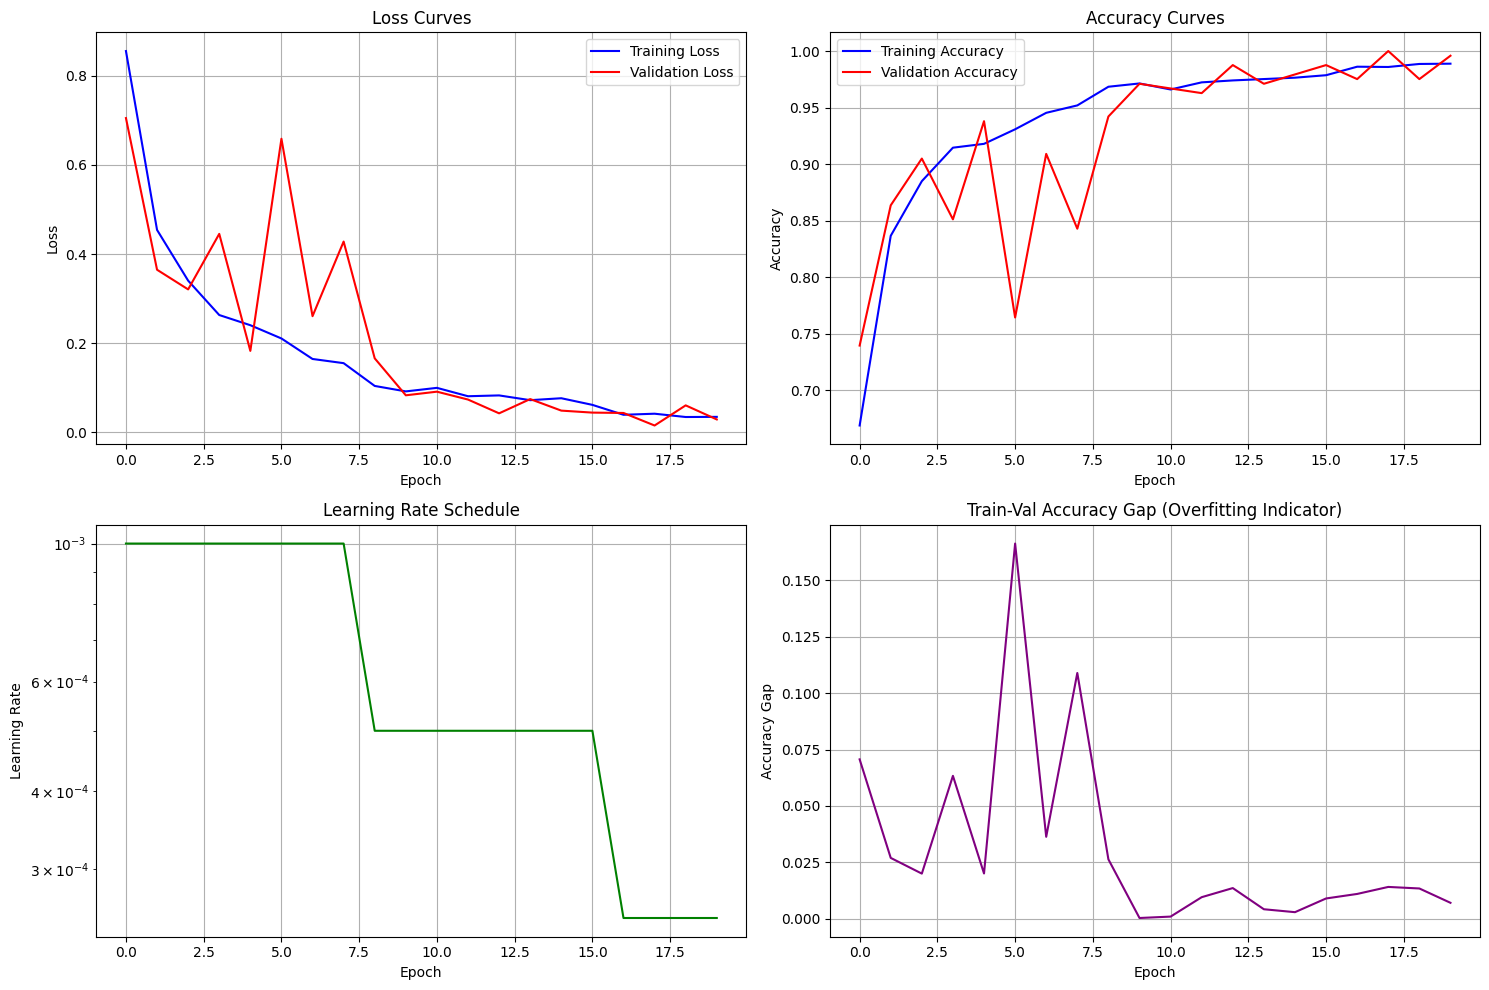

In [43]:
# %% GENERATE TRAINING/VALIDATION CURVES (NO RETRAINING NEEDED!)
def plot_training_curves(training_history):
    """Plot training and validation curves"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss curves
    axes[0,0].plot(training_history['train_losses'], label='Training Loss', color='blue')
    axes[0,0].plot(training_history['val_losses'], label='Validation Loss', color='red')
    axes[0,0].set_title('Loss Curves')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True)
    
    # Accuracy curves
    axes[0,1].plot(training_history['train_accuracies'], label='Training Accuracy', color='blue')
    axes[0,1].plot(training_history['val_accuracies'], label='Validation Accuracy', color='red')
    axes[0,1].set_title('Accuracy Curves')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Accuracy')
    axes[0,1].legend()
    axes[0,1].grid(True)
    
    # Learning rate curve
    axes[1,0].plot(training_history['learning_rates'], color='green')
    axes[1,0].set_title('Learning Rate Schedule')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Learning Rate')
    axes[1,0].grid(True)
    axes[1,0].set_yscale('log')
    
    # Overfitting analysis (gap between train and val)
    train_val_gap = [abs(train - val) for train, val in zip(
        training_history['train_accuracies'], training_history['val_accuracies'])]
    axes[1,1].plot(train_val_gap, color='purple')
    axes[1,1].set_title('Train-Val Accuracy Gap (Overfitting Indicator)')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('Accuracy Gap')
    axes[1,1].grid(True)
    
    plt.tight_layout()
    plt.savefig('training_curves.pdf', dpi=300, bbox_inches='tight')
    plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save training curves data
    training_curves_data = {
        'epochs': list(range(1, len(training_history['train_losses']) + 1)),
        'train_losses': training_history['train_losses'],
        'val_losses': training_history['val_losses'],
        'train_accuracies': training_history['train_accuracies'],
        'val_accuracies': training_history['val_accuracies'],
        'learning_rates': training_history['learning_rates'],
        'train_val_gap': train_val_gap
    }
    
    with open('results/training_curves_data.json', 'w') as f:
        json.dump(training_curves_data, f, indent=4)

# Load training history and plot curves (NO RETRAINING!)
with open('results/training_history.json', 'r') as f:
    training_history = json.load(f)

plot_training_curves(training_history)

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from tqdm import tqdm

# Model Definition: CustomCNNWithLSTM
class CustomCNNWithLSTM(nn.Module):
    def __init__(self, num_classes=6, lstm_hidden_size=128, lstm_num_layers=2):
        super(CustomCNNWithLSTM, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout_cnn = nn.Dropout(0.3)

        # LSTM
        self.lstm_input_size = 128
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_size,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_num_layers,
            batch_first=True,
            bidirectional=True
        )

        self.fc1 = nn.Linear(lstm_hidden_size * 2, 256)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout_cnn(x)

        # Flatten for LSTM input
        batch_size, channels, height, width = x.shape
        x = x.view(batch_size, channels, -1).permute(0, 2, 1)

        # LSTM
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x


# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    model.to(device)
    best_loss = float('inf')

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        # Training Phase
        model.train()
        train_loss = 0.0
        train_corrects = 0

        # Use tqdm for training progress bar
        for inputs, labels in tqdm(train_loader, desc="Training", ncols=100, dynamic_ncols=True):
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_corrects += torch.sum(preds == labels.data)

        scheduler.step()
        epoch_loss = train_loss / len(train_loader.dataset)
        epoch_acc = train_corrects.double() / len(train_loader.dataset)

        print(f"Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        # Use tqdm for validation progress bar
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation", ncols=100, dynamic_ncols=True):
                inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = val_corrects.double() / len(val_loader.dataset)

        print(f"Validation Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

        # Save the best model
        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print("Model saved as best_model.pth")

    print("Training complete.")
    print(f"Best Validation Loss: {best_loss:.4f}")


# Example Usage
if __name__ == "__main__":
    # Define the DataLoader instances (train_loader and val_loader) with your data

    num_classes = 6
    model_cnn_lstm = CustomCNNWithLSTM(num_classes=num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_cnn_lstm.parameters(), lr=0.0001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Train the model (replace train_loader and val_loader with your actual data loaders)
    train_model(
        model_cnn_lstm,
        train_loader,  # Your DataLoader for training data
        val_loader,    # Your DataLoader for validation data
        criterion,
        optimizer,
        scheduler,
        num_epochs=15,
        device=device
    )


Epoch 1/15
----------


Training: 100%|██████████| 516/516 [01:41<00:00,  5.10it/s]


Training Loss: 1.5232 Acc: 0.3421


Validation: 100%|██████████| 31/31 [00:05<00:00,  5.94it/s]


Validation Loss: 1.2270 Acc: 0.4835
Model saved as best_model.pth
Epoch 2/15
----------


Training: 100%|██████████| 516/516 [01:31<00:00,  5.67it/s]


Training Loss: 1.0247 Acc: 0.5773


Validation: 100%|██████████| 31/31 [00:05<00:00,  6.01it/s]


Validation Loss: 0.8443 Acc: 0.6736
Model saved as best_model.pth
Epoch 3/15
----------


Training: 100%|██████████| 516/516 [01:31<00:00,  5.63it/s]


Training Loss: 0.8996 Acc: 0.6282


Validation: 100%|██████████| 31/31 [00:05<00:00,  5.84it/s]


Validation Loss: 1.0284 Acc: 0.5702
Epoch 4/15
----------


Training: 100%|██████████| 516/516 [01:32<00:00,  5.58it/s]


Training Loss: 0.6967 Acc: 0.7156


Validation: 100%|██████████| 31/31 [00:05<00:00,  6.09it/s]


Validation Loss: 2.3352 Acc: 0.3471
Epoch 5/15
----------


Training: 100%|██████████| 516/516 [01:28<00:00,  5.85it/s]


Training Loss: 0.6063 Acc: 0.7586


Validation: 100%|██████████| 31/31 [00:05<00:00,  6.13it/s]


Validation Loss: 0.5075 Acc: 0.8017
Model saved as best_model.pth
Epoch 6/15
----------


Training: 100%|██████████| 516/516 [01:29<00:00,  5.75it/s]


Training Loss: 0.5122 Acc: 0.8015


Validation: 100%|██████████| 31/31 [00:05<00:00,  6.01it/s]


Validation Loss: 0.4112 Acc: 0.8471
Model saved as best_model.pth
Epoch 7/15
----------


Training: 100%|██████████| 516/516 [01:30<00:00,  5.70it/s]


Training Loss: 0.4494 Acc: 0.8287


Validation: 100%|██████████| 31/31 [00:05<00:00,  6.10it/s]


Validation Loss: 0.3845 Acc: 0.8843
Model saved as best_model.pth
Epoch 8/15
----------


Training: 100%|██████████| 516/516 [01:29<00:00,  5.77it/s]


Training Loss: 0.3208 Acc: 0.8898


Validation: 100%|██████████| 31/31 [00:05<00:00,  6.16it/s]


Validation Loss: 0.2946 Acc: 0.9008
Model saved as best_model.pth
Epoch 9/15
----------


Training: 100%|██████████| 516/516 [01:28<00:00,  5.81it/s]


Training Loss: 0.3068 Acc: 0.8925


Validation: 100%|██████████| 31/31 [00:05<00:00,  6.09it/s]


Validation Loss: 0.2577 Acc: 0.9215
Model saved as best_model.pth
Epoch 10/15
----------


Training: 100%|██████████| 516/516 [01:29<00:00,  5.77it/s]


Training Loss: 0.2721 Acc: 0.9107


Validation: 100%|██████████| 31/31 [00:05<00:00,  6.08it/s]


Validation Loss: 0.2444 Acc: 0.9256
Model saved as best_model.pth
Epoch 11/15
----------


Training: 100%|██████████| 516/516 [01:29<00:00,  5.77it/s]


Training Loss: 0.2590 Acc: 0.9107


Validation: 100%|██████████| 31/31 [00:04<00:00,  6.48it/s]


Validation Loss: 0.2343 Acc: 0.9215
Model saved as best_model.pth
Epoch 12/15
----------


Training: 100%|██████████| 516/516 [01:23<00:00,  6.16it/s]


Training Loss: 0.2414 Acc: 0.9211


Validation: 100%|██████████| 31/31 [00:04<00:00,  6.71it/s]


Validation Loss: 0.2224 Acc: 0.9298
Model saved as best_model.pth
Epoch 13/15
----------


Training: 100%|██████████| 516/516 [01:22<00:00,  6.23it/s]


Training Loss: 0.2316 Acc: 0.9219


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.29it/s]


Validation Loss: 0.1899 Acc: 0.9463
Model saved as best_model.pth
Epoch 14/15
----------


Training: 100%|██████████| 516/516 [01:18<00:00,  6.58it/s]


Training Loss: 0.2248 Acc: 0.9250


Validation: 100%|██████████| 31/31 [00:04<00:00,  6.55it/s]


Validation Loss: 0.1698 Acc: 0.9504
Model saved as best_model.pth
Epoch 15/15
----------


Training: 100%|██████████| 516/516 [01:20<00:00,  6.37it/s]


Training Loss: 0.2041 Acc: 0.9357


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.12it/s]

Validation Loss: 0.1834 Acc: 0.9545
Training complete.
Best Validation Loss: 0.1698


C:\Users\incha\AppData\Local\Temp\ipykernel_26428\1704837883.py:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_deepercnn.load_state_dict(torch.load("best_model.pth

Test Loss: 0.2539 Test Acc: 0.9198
Average Inference Time per Batch: 0.1878 seconds

Classification Report:
{'3 Long Blade Rotor': {'precision': 0.9102564102564102, 'recall': 0.8452380952380952, 'f1-score': 0.8765432098765432, 'support': 84.0}, '3 Short Blade Rotor': {'precision': 0.7802197802197802, 'recall': 0.8875, 'f1-score': 0.8304093567251462, 'support': 80.0}, 'Bird': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 80.0}, 'Bird+mini-helicopter': {'precision': 0.9746835443037974, 'recall': 0.9166666666666666, 'f1-score': 0.9447852760736196, 'support': 84.0}, 'Drone': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 78.0}, 'RC Plane': {'precision': 0.875, 'recall': 0.875, 'f1-score': 0.875, 'support': 80.0}, 'accuracy': 0.9197530864197531, 'macro avg': {'precision': 0.9233599557966646, 'recall': 0.920734126984127, 'f1-score': 0.9211229737792181, 'support': 486.0}, 'weighted avg': {'precision': 0.9233591329231273, 'recall': 0.9197530864197531, 'f1-score':

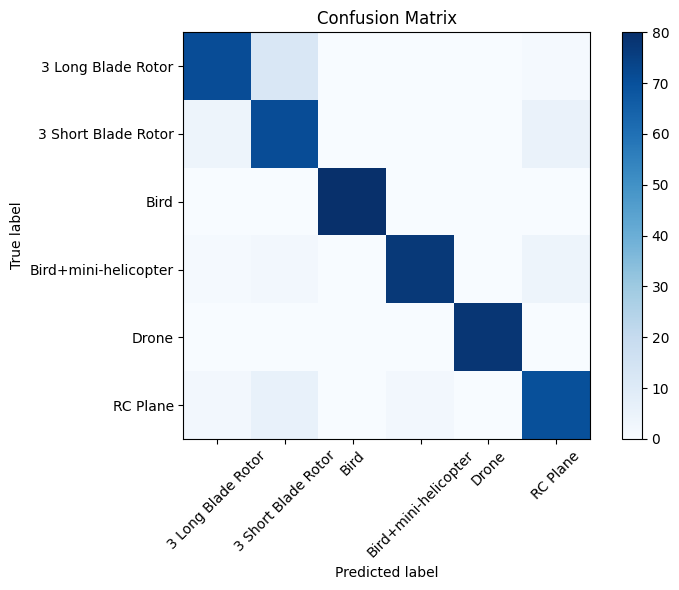

Macro Average AUC: 0.9889


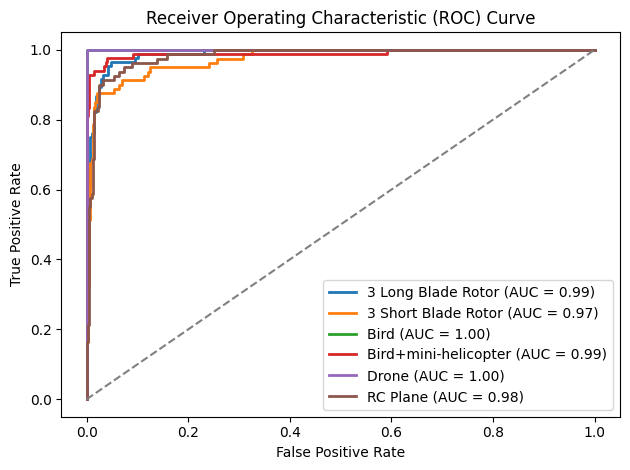

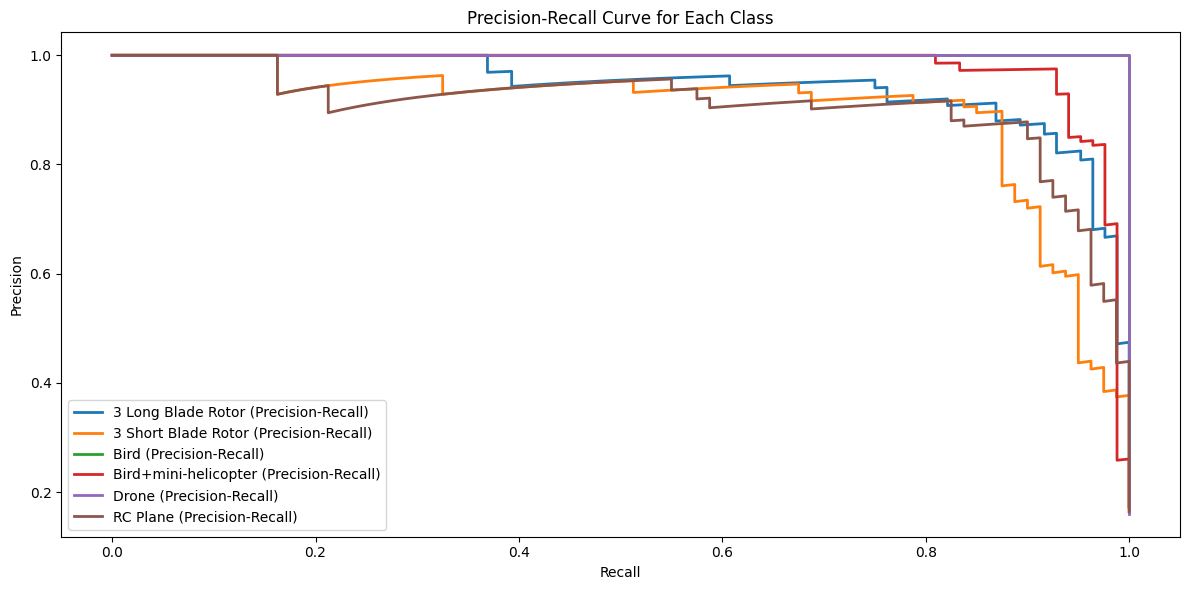

Class Distribution in Test Set: {'3 Long Blade Rotor': 84, '3 Short Blade Rotor': 80, 'Bird': 80, 'Bird+mini-helicopter': 84, 'Drone': 78, 'RC Plane': 80}


c:\Users\incha\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\onnx\symbolic_opset9.py:4545: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


Model exported to ONNX format successfully.


In [34]:
import torch
import torch.nn as nn
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import torch.nn.functional as F
import time
import json
from sklearn.calibration import calibration_curve

# Class names for your classification task
class_names = [
    "3 Long Blade Rotor", 
    "3 Short Blade Rotor", 
    "Bird", 
    "Bird+mini-helicopter", 
    "Drone", 
    "RC Plane"
]

# Test Function with Metric Collection
def test_model(model, test_loader, criterion, device="cuda" if torch.cuda.is_available() else "cpu"):
    model = model.to(device)
    model.eval()

    running_loss = 0.0
    running_corrects = 0
    total_test = 0
    all_preds = []
    all_labels = []
    all_probs = []

    # Start time for inference benchmark
    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device).long()

            # Forward Pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            # Store metrics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_test += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(F.softmax(outputs, dim=1).cpu().numpy())

    # End time for inference benchmark
    end_time = time.time()
    avg_inference_time = (end_time - start_time) / len(test_loader)

    # Overall metrics
    test_loss = running_loss / total_test
    test_acc = running_corrects.double() / total_test

    print(f"Test Loss: {test_loss:.4f} Test Acc: {test_acc:.4f}")
    print(f"Average Inference Time per Batch: {avg_inference_time:.4f} seconds")

    # Classification Report
    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    print(report)

    # Save Classification Report to a JSON file
    with open("classification_report.json", "w") as f:
        json.dump(report, f, indent=4)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Save confusion matrix
    np.save("confusion_matrix.npy", cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

    # ROC Curve & AUC (for multiclass)
    all_probs = np.array(all_probs)
    if len(class_names) > 2:
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(len(class_names)):
            fpr[i], tpr[i], _ = roc_curve((np.array(all_labels) == i).astype(int), all_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

        # Macro average AUC
        macro_auc = np.mean([auc(fpr[i], tpr[i]) for i in range(len(class_names))])
        print(f"Macro Average AUC: {macro_auc:.4f}")

        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.show()

    return all_labels, all_preds, all_probs, macro_auc

# Precision-Recall Curve Plot
def plot_precision_and_recall(all_labels, all_probs, class_names):
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    plt.figure(figsize=(12, 6))
    for i, class_name in enumerate(class_names):
        precision, recall, _ = precision_recall_curve((all_labels == i).astype(int), all_probs[:, i])
        plt.plot(recall, precision, lw=2, label=f'{class_name} (Precision-Recall)')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Each Class')
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

# Check for class distribution (Imbalanced Data Check)
def check_class_distribution(all_labels, class_names):
    unique, counts = np.unique(all_labels, return_counts=True)
    class_distribution = dict(zip(class_names, counts))
    print("Class Distribution in Test Set:", class_distribution)

# Example Usage
if __name__ == "__main__":
    # Initialize Model and Data
    model_deepercnn = CustomCNNWithLSTM(num_classes=len(class_names))
    model_deepercnn.load_state_dict(torch.load("best_model.pth"))
    criterion = nn.CrossEntropyLoss()

    # Test Model
    all_labels, all_preds, all_probs, macro_auc = test_model(model_deepercnn, test_loader, criterion)

    # Plot Precision-Recall Curves
    plot_precision_and_recall(all_labels, all_probs, class_names)

    # Check for Class Imbalance
    check_class_distribution(all_labels, class_names)

    # Prepare for ONNX Conversion (Optional)
    dummy_input = torch.randn(1, 3, 224, 224, device="cuda" if torch.cuda.is_available() else "cpu")  # Adjust for your input size
    torch.onnx.export(model_deepercnn, dummy_input, "model.onnx", input_names=['input'], output_names=['output'])

    print("Model exported to ONNX format successfully.")

In [37]:
from sklearn.metrics import classification_report, confusion_matrix
import torch

def test_model(model, test_loader, device="cuda" if torch.cuda.is_available() else "cpu"):
    model = model.to(device)
    model.eval()
    
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).long()  # Ensure labels are of type torch.long

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Collect predictions and targets
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    
    # Generate Classification Report
    print("Classification Report:")
    print(classification_report(all_targets, all_preds, digits=4))

    # Generate Confusion Matrix
    print("Confusion Matrix:")
    print(confusion_matrix(all_targets, all_preds))

# Example Usage
# Assuming test_loader is defined
if __name__ == "__main__":
    # Load the trained model weights
    model_deepercnn = CustomCNNWithAttention(num_classes=6)
    model_deepercnn.load_state_dict(torch.load("customcnnwithAttention.pth"))

    # Evaluate the model on test data
    test_model(model_deepercnn, test_loader)


C:\Users\Shravya H Jain\AppData\Local\Temp\ipykernel_22584\66978296.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_deepercnn.load_state_dict(torch.load("customcn

Classification Report:
              precision    recall  f1-score   support

           0     0.9630    0.9286    0.9455        84
           1     0.9059    0.9625    0.9333        80
           2     1.0000    1.0000    1.0000        80
           3     1.0000    0.9762    0.9880        84
           4     1.0000    1.0000    1.0000        78
           5     0.9750    0.9750    0.9750        80

    accuracy                         0.9733       486
   macro avg     0.9740    0.9737    0.9736       486
weighted avg     0.9740    0.9733    0.9734       486

Confusion Matrix:
[[78  6  0  0  0  0]
 [ 3 77  0  0  0  0]
 [ 0  0 80  0  0  0]
 [ 0  0  0 82  0  2]
 [ 0  0  0  0 78  0]
 [ 0  2  0  0  0 78]]


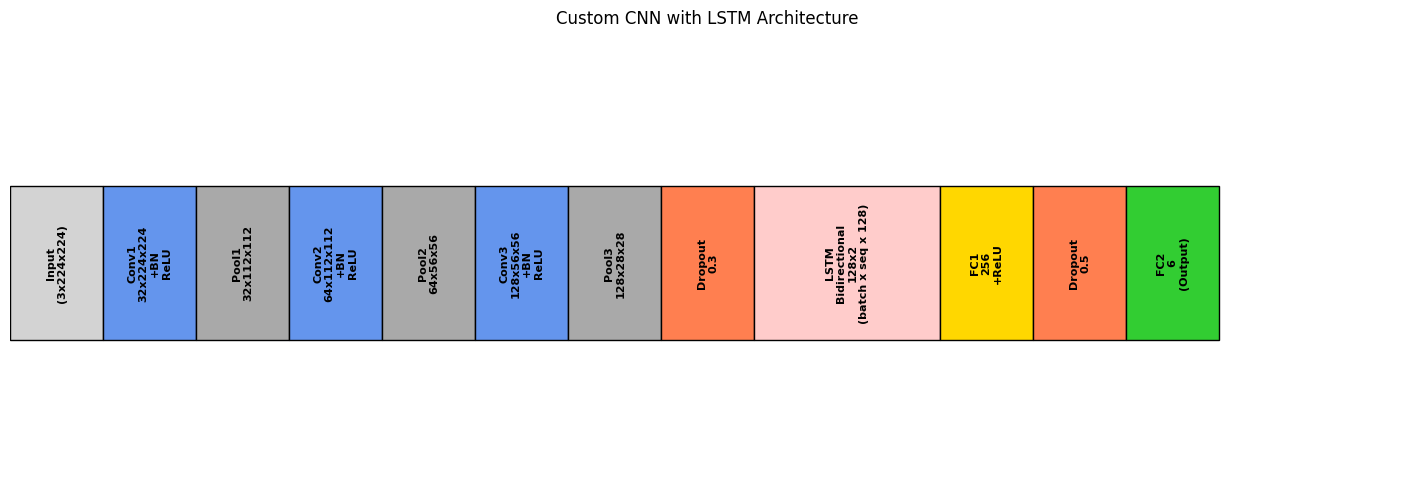

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define colors for different types of layers
colors = {
    'input': '#d3d3d3',  # Light gray for Input Layer
    'conv': '#6495ed',   # Blue for Convolution + BatchNorm + ReLU
    'pool': '#a9a9a9',   # Dark gray for Max Pooling
    'dropout': '#ff7f50',  # Coral for Dropout
    'lstm': '#ffcccb',   # Light Red for LSTM
    'dense': '#ffd700',  # Gold for Fully Connected + Dropout
    'output': '#32cd32'  # Lime for Output
}

def draw_block(ax, x, y, width, height, label, color):
    """Helper function to draw a rectangular block with text."""
    rect = patches.Rectangle((x, y), width, height, edgecolor='black', facecolor=color)
    ax.add_patch(rect)
    ax.text(x + width / 2, y + height / 2, label, color='black',
            ha='center', va='center', fontsize=8, weight="bold", rotation=90)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(18, 6))

# Block dimensions
block_width = 0.5

# Draw the Input Layer
draw_block(ax, 0, 1, block_width, 1, 'Input\n(3x224x224)', colors['input'])

# Convolutional and Pooling Layers
layers = [
    ('Conv1\n32x224x224\n+BN\nReLU', colors['conv']),
    ('Pool1\n32x112x112', colors['pool']),
    ('Conv2\n64x112x112\n+BN\nReLU', colors['conv']),
    ('Pool2\n64x56x56', colors['pool']),
    ('Conv3\n128x56x56\n+BN\nReLU', colors['conv']),
    ('Pool3\n128x28x28', colors['pool']),
    ('Dropout\n0.3', colors['dropout']),
]

x_offset = block_width
for layer, color in layers:
    draw_block(ax, x_offset, 1, block_width, 1, layer, color)
    x_offset += block_width

# LSTM Layer
draw_block(ax, x_offset, 1, block_width * 2, 1, 'LSTM\nBidirectional\n128x2\n(batch x seq x 128)', colors['lstm'])
x_offset += block_width * 2

# Fully Connected Layers
fc_layers = [
    ('FC1\n256\n+ReLU', colors['dense']),
    ('Dropout\n0.5', colors['dropout']),
    ('FC2\n6\n(Output)', colors['output'])
]

for layer, color in fc_layers:
    draw_block(ax, x_offset, 1, block_width, 1, layer, color)
    x_offset += block_width

# Configure plot
ax.set_xlim(0, x_offset + 1)
ax.set_ylim(0, 3)
ax.axis('off')

# Title
plt.title('Custom CNN with LSTM Architecture')
plt.show()


In [25]:
# %% Imports
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from PIL import Image

# %% Attention Mechanism
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_size * 2, 1)

    def forward(self, lstm_output):
        attention_weights = torch.softmax(self.attention(lstm_output), dim=1)
        context_vector = torch.sum(attention_weights * lstm_output, dim=1)
        return context_vector

# %% CNN with LSTM and Attention
class CustomCNNWithLSTM(nn.Module):
    def __init__(self, num_classes=6, lstm_hidden_size=256, lstm_num_layers=2):
        super(CustomCNNWithLSTM, self).__init__()
        # CNN Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # LSTM Layers
        self.lstm = nn.LSTM(
            input_size=256,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_num_layers,
            batch_first=True,
            bidirectional=True
        )

        # Attention Layer
        self.attention = Attention(lstm_hidden_size)

        # Fully Connected Layers
        self.fc1 = nn.Linear(lstm_hidden_size * 2, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))

        # Flatten for LSTM
        batch_size, channels, height, width = x.size()
        x = x.view(batch_size, channels, -1).permute(0, 2, 1)

        # LSTM + Attention
        lstm_out, _ = self.lstm(x)
        x = self.attention(lstm_out)

        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# %% Custom Dataset
class CustomImageDataset(Dataset):
    def __init__(self, base_dir, subfolders, transform=None, label_encoder=None):
        self.image_paths = []
        self.labels = []
        for subfolder in subfolders:
            folder_path = os.path.join(base_dir, subfolder)
            for img_name in os.listdir(folder_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(folder_path, img_name))
                    self.labels.append(subfolder)
        if label_encoder:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.labels)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# %% Data Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# %% Dataset Preparation
base_dir = "DIAT-uSAT_dataset"
subfolders = ["3_long_blade_rotor", "3_short_blade_rotor", "Bird", "Bird+mini-helicopter", "drone", "rc_plane"]

label_encoder = LabelEncoder()
label_encoder.fit(subfolders)

train_dataset = CustomImageDataset(base_dir, subfolders, transform, label_encoder)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# %% Data Loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# %% Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNNWithLSTM(num_classes=len(subfolders)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# %% Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_preds, train_labels = [], []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).long()  # Ensure labels are of type long

            outputs = model(images)

            # Ensure outputs and labels have correct shapes
            assert outputs.shape[1] == len(subfolders), "Output classes don't match the number of labels"

            loss = criterion(outputs, labels)  # Labels should be of type long

            optimizer.zero_grad()  # Clear previous gradients
            loss.backward()  # Compute gradients
            optimizer.step()  # Update model parameters

            train_loss += loss.item()
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())  # Get predicted class labels
            train_labels.extend(labels.cpu().numpy())  # Get true class labels

        train_acc = accuracy_score(train_labels, train_preds)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).long()

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)
        print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Acc: {val_acc:.4f}")

# %% Train Model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

torch.save(model.state_dict(), "custom_cnn_lstm_model.pth")
print("Model saved!")


Epoch 1/20, Train Loss: 0.9637, Train Acc: 0.6081
Validation Loss: 1.6030, Validation Acc: 0.4990
Epoch 2/20, Train Loss: 0.6486, Train Acc: 0.7564
Validation Loss: 0.4759, Validation Acc: 0.8289
Epoch 3/20, Train Loss: 0.4112, Train Acc: 0.8551
Validation Loss: 0.3839, Validation Acc: 0.8732
Epoch 4/20, Train Loss: 0.3462, Train Acc: 0.8814
Validation Loss: 0.9806, Validation Acc: 0.7155
Epoch 5/20, Train Loss: 0.3261, Train Acc: 0.8866
Validation Loss: 0.5992, Validation Acc: 0.8216
Epoch 6/20, Train Loss: 0.2721, Train Acc: 0.9033
Validation Loss: 0.2847, Validation Acc: 0.9113
Epoch 7/20, Train Loss: 0.2255, Train Acc: 0.9268
Validation Loss: 0.2577, Validation Acc: 0.9186
Epoch 8/20, Train Loss: 0.2269, Train Acc: 0.9301
Validation Loss: 0.1997, Validation Acc: 0.9423
Epoch 9/20, Train Loss: 0.1701, Train Acc: 0.9469
Validation Loss: 0.2421, Validation Acc: 0.9258
Epoch 10/20, Train Loss: 0.1698, Train Acc: 0.9461
Validation Loss: 0.2228, Validation Acc: 0.9381
Epoch 11/20, Train 

In [2]:
import onnxruntime as ort
import numpy as np
from PIL import Image
from torchvision import transforms
import time

# Load the ONNX model
model_path = "cnnwithattention.onnx"
session = ort.InferenceSession(model_path, providers=["CPUExecutionProvider"])

# Get input and output information
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
input_shape = session.get_inputs()[0].shape

# Print input shape to understand the expected input dimensions
print(f"Expected input shape: {input_shape}")

# Define the preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Define the six classes
classes = ["3 Long Blade Rotor", "3 Short Blade Rotor", "Bird", "Bird+mini-helicopter", "Drone", "RC Plane"]

# Load an image (replace with the path to your image)
image_path = "D:/Micro-Classify/ml_model/notebooks/DIAT-uSAT_dataset/3_long_blade_rotor/figure1.jpg"
image = Image.open(image_path)

# Apply the transformations
input_tensor = transform(image)

# Add a batch dimension (since ONNX model expects a batch of images)
input_tensor = input_tensor.unsqueeze(0)  # Shape becomes (1, 3, 224, 224)

# Convert the tensor to a numpy array
input_array = input_tensor.numpy()

# Start timer for inference
start_time = time.time()

# Run the inference
output = session.run([output_name], {input_name: input_array})

# End timer for inference
end_time = time.time()

# Calculate inference time
inference_time = end_time - start_time

# Process the output
output_probabilities = np.squeeze(output[0])  # Remove unnecessary dimensions
predicted_class = np.argmax(output_probabilities)  # Get index of the highest probability

# Display results
print(f"Predicted Class: {classes[predicted_class]}")
print(f"Probability: {output_probabilities[predicted_class]:.4f}")
print(f"Inference Time: {inference_time:.4f} seconds")

Expected input shape: [1, 3, 224, 224]
Predicted Class: 3 Long Blade Rotor
Probability: 2.3634
Inference Time: 0.0090 seconds


In [3]:
import onnxruntime as ort
import numpy as np
from PIL import Image
from torchvision import transforms
import os
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Load the ONNX model
model_path = "cnnwithattention.onnx"
session = ort.InferenceSession(model_path, providers=["CPUExecutionProvider"])

# Get input and output information
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

# Define the preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Define the six classes
classes = ["3_long_blade_rotor", "3_short_blade_rotor", "Bird", "Bird+mini-helicopter", "drone", "rc_plane"]

def preprocess_image(image_path):
    """
    Preprocess an image for model inference
    """
    image = Image.open(image_path)
    input_tensor = transform(image)
    input_tensor = input_tensor.unsqueeze(0)
    return input_tensor.numpy().astype(np.float32)

def predict_image(session, input_array, input_name, output_name):
    """
    Run inference on a single image
    """
    output = session.run([output_name], {input_name: input_array})
    output_probabilities = np.squeeze(output[0])
    return np.argmax(output_probabilities)

def evaluate_model(dataset_root):
    """
    Evaluate the ONNX model and generate classification report
    
    :param dataset_root: Root directory containing subdirectories for each class
    :return: Tuple of (true labels, predicted labels)
    """
    true_labels = []
    predicted_labels = []
    
    # Iterate through each class directory
    for class_idx, class_name in enumerate(classes):
        class_path = os.path.join(dataset_root, class_name)
        
        # Check if directory exists
        if not os.path.isdir(class_path):
            print(f"Warning: Directory {class_path} does not exist.")
            continue
        
        # Process each image in the class directory
        for image_filename in os.listdir(class_path):
            image_path = os.path.join(class_path, image_filename)
            
            try:
                # Preprocess the image
                input_array = preprocess_image(image_path)
                
                # Predict the class
                predicted_class = predict_image(session, input_array, input_name, output_name)
                
                # Store true and predicted labels
                true_labels.append(class_idx)
                predicted_labels.append(predicted_class)
            
            except Exception as e:
                print(f"Error processing {image_path}: {e}")
    
    return true_labels, predicted_labels

def generate_classification_report(dataset_root):
    """
    Generate and print classification report
    
    :param dataset_root: Root directory containing subdirectories for each class
    """
    # Evaluate the model
    true_labels, predicted_labels = evaluate_model(dataset_root)
    
    # Generate classification report
    report = classification_report(
        true_labels, 
        predicted_labels, 
        target_names=classes, 
        digits=4
    )
    print("Classification Report:")
    print(report)
    
    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10,8))
    
    # Create confusion matrix with Matplotlib
    im = plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar(im)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(range(len(classes)), classes, rotation=45)
    plt.yticks(range(len(classes)), classes)
    plt.savefig('confusion_matrix.png')
    plt.close()

# Usage
# Replace with the path to your test dataset root directory
dataset_root = "D:/Micro-Classify/ml_model/notebooks/DIAT-uSAT_dataset"
generate_classification_report(dataset_root)

c:\Users\incha\AppData\Local\Programs\Python\Python310\lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Classification Report:
                      precision    recall  f1-score   support

  3_long_blade_rotor     0.9949    0.9800    0.9874       799
 3_short_blade_rotor     0.9803    0.9938    0.9870       800
                Bird     1.0000    1.0000    1.0000       800
Bird+mini-helicopter     0.9843    0.9988    0.9915       815
               drone     1.0000    1.0000    1.0000       835
            rc_plane     0.9975    0.9838    0.9906       800

            accuracy                         0.9928      4849
           macro avg     0.9928    0.9927    0.9927      4849
        weighted avg     0.9928    0.9928    0.9928      4849

